In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.optimize import fsolve

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


## DATA

In [4]:
title = "LQ down 1400 GeV"

In [5]:
##############
# input data #
##############

# b1,b2 -> (pT, eta, phi) from the leading and second b-tagged jets
# tau -> (pT, eta, phi) from the tau
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, num_jets, num_btag)  HT: sum PT of all the jets, number of jets (b-tag or not), number of b-tagged jets


################
# New Physics: #
################

datFolderNP = '../DATA/signal/dats-LQdown-1400GeV/'
k_LQdown = 1.8247261601649074
crossfidNP = 0.036648580197600006*k_LQdown

b1_NP = np.loadtxt(datFolderNP + 'b1.dat', delimiter=' ')
b2_NP = np.loadtxt(datFolderNP + 'b2.dat', delimiter=' ')
tau_NP = np.loadtxt(datFolderNP + 'tau.dat', delimiter=' ')
MET_NP = np.loadtxt(datFolderNP + 'MET.dat', delimiter=' ')
hadinfo_NP = np.loadtxt(datFolderNP + 'hadinfo.dat', delimiter=' ')

print('# eventos LQ: ', len(b1_NP))



###############
# Background: #
###############

# tt and fakett

datFolderSM_tt = '../DATA/background/dats-tt/'

k_fakett = 1.1053030485310749
crossfid_fakett = 0.244
k_tt = 1.2593273872014419
crossfid_tt = (7.74198*k_tt) + (crossfid_fakett * k_fakett)

b1_SM_tt = np.loadtxt(datFolderSM_tt + 'b1.dat', delimiter=' ')
b2_SM_tt = np.loadtxt(datFolderSM_tt + 'b2.dat', delimiter=' ')
tau_SM_tt = np.loadtxt(datFolderSM_tt + 'tau.dat', delimiter=' ')
MET_SM_tt = np.loadtxt(datFolderSM_tt + 'MET.dat', delimiter=' ')
hadinfo_SM_tt = np.loadtxt(datFolderSM_tt + 'hadinfo.dat', delimiter=' ')

print('# eventos tt: ', len(b1_SM_tt))


# singlet part 1

datFolderSM_singletP1 = '../DATA/background/dats-singletP1/'
k_singletTOTAL = 3.440676833094312 # it is the total k_singlet
crossfid_singletP1 = 0.632632*k_singletTOTAL

b1_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'b1.dat', delimiter=' ')
b2_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'b2.dat', delimiter=' ')
tau_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'tau.dat', delimiter=' ')
MET_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'MET.dat', delimiter=' ')
hadinfo_SM_singletP1 = np.loadtxt(datFolderSM_singletP1 + 'hadinfo.dat', delimiter=' ')

print('# eventos singlet part 1: ', len(b1_SM_singletP1))


# singlet part 2

datFolderSM_singletP2 = '../DATA/background/dats-singlet-comp/'
k_singletTOTAL = 3.440676833094312 # it is the total k_singlet
crossfid_singletP2 = 0.3182704*k_singletTOTAL

b1_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'b1.dat', delimiter=' ')
b2_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'b2.dat', delimiter=' ')
tau_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'tau.dat', delimiter=' ')
MET_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'MET.dat', delimiter=' ')
hadinfo_SM_singletP2 = np.loadtxt(datFolderSM_singletP2 + 'hadinfo.dat', delimiter=' ')

print('# eventos singlet part 2: ', len(b1_SM_singletP2))


# Wbbjets

datFolderSM_Wbbjets = '../DATA/background/dats-Wbbjets/'
k_wjets = 0.9781509289273502
crossfid_Wbbjets = 1.6542420183645095*k_wjets

b1_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'b1.dat', delimiter=' ')
b2_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'b2.dat', delimiter=' ')
tau_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'tau.dat', delimiter=' ')
MET_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'MET.dat', delimiter=' ')
hadinfo_SM_Wbbjets = np.loadtxt(datFolderSM_Wbbjets + 'hadinfo.dat', delimiter=' ')

print('# eventos Wbbjets: ', len(b1_SM_Wbbjets))


# ttW (part of ttV)

datFolderSM_ttW = '../DATA/background/dats-ttW/'
k_ttV = 3.056401327463198 # it is the total ttV
crossfid_ttW = 0.03683196*k_ttV

b1_SM_ttW = np.loadtxt(datFolderSM_ttW + 'b1.dat', delimiter=' ')
b2_SM_ttW = np.loadtxt(datFolderSM_ttW + 'b2.dat', delimiter=' ')
tau_SM_ttW = np.loadtxt(datFolderSM_ttW + 'tau.dat', delimiter=' ')
MET_SM_ttW = np.loadtxt(datFolderSM_ttW + 'MET.dat', delimiter=' ')
hadinfo_SM_ttW = np.loadtxt(datFolderSM_ttW + 'hadinfo.dat', delimiter=' ')

print('# eventos ttW: ', len(b1_SM_ttW))


# ttZ

datFolderSM_ttZ = '../DATA/background/dats-ttZ/'
k_ttV = 3.056401327463198 # it is the total ttV
crossfid_ttZ = 0.0715444*k_ttV

b1_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'b1.dat', delimiter=' ')
b2_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'b2.dat', delimiter=' ')
tau_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'tau.dat', delimiter=' ')
MET_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'MET.dat', delimiter=' ')
hadinfo_SM_ttZ = np.loadtxt(datFolderSM_ttZ + 'hadinfo.dat', delimiter=' ')

print('# eventos ttZ: ', len(b1_SM_ttZ))


# ttH

datFolderSM_ttH = '../DATA/background/dats-ttH/'
k_ttH = 2.2127445612386474
crossfid_ttH = 0.03630132*k_ttH

b1_SM_ttH = np.loadtxt(datFolderSM_ttH + 'b1.dat', delimiter=' ')
b2_SM_ttH = np.loadtxt(datFolderSM_ttH + 'b2.dat', delimiter=' ')
tau_SM_ttH = np.loadtxt(datFolderSM_ttH + 'tau.dat', delimiter=' ')
MET_SM_ttH = np.loadtxt(datFolderSM_ttH + 'MET.dat', delimiter=' ')
hadinfo_SM_ttH = np.loadtxt(datFolderSM_ttH + 'hadinfo.dat', delimiter=' ')

print('# eventos ttH: ', len(b1_SM_ttH))

# eventos LQ:  474516
# eventos tt:  826022
# eventos singlet part 1:  179677
# eventos singlet part 2:  94219
# eventos Wbbjets:  162448
# eventos ttW:  141919
# eventos ttZ:  16178
# eventos ttH:  12068


In [6]:
# Number of data points (per-class) for the ML classifier
num_data_NP = int(len(b1_NP)-1)
print(' SIGNAL ')
print('# S chosen: ', num_data_NP)



totalcrossSM = crossfid_tt + crossfid_singletP1+crossfid_singletP2 + crossfid_Wbbjets + crossfid_ttW+crossfid_ttZ + crossfid_ttH

num_data_SM_singletP1 = round( num_data_NP * (crossfid_singletP1/totalcrossSM) )
num_data_SM_singletP2 = round( num_data_NP * (crossfid_singletP2/totalcrossSM) )
num_data_SM_Wbbjets = round( num_data_NP * (crossfid_Wbbjets/totalcrossSM) )
num_data_SM_ttW = round( num_data_NP * (crossfid_ttW/totalcrossSM) )
num_data_SM_ttZ = round( num_data_NP * (crossfid_ttZ/totalcrossSM) )
num_data_SM_ttH = round( num_data_NP * (crossfid_ttH/totalcrossSM) )

num_data_SM_tt = num_data_NP - (num_data_SM_singletP1+num_data_SM_singletP2 + num_data_SM_Wbbjets + num_data_SM_ttW+num_data_SM_ttZ + num_data_SM_ttH)

num_data_SM = num_data_SM_tt + num_data_SM_singletP1+num_data_SM_singletP2 + num_data_SM_Wbbjets + num_data_SM_ttW+num_data_SM_ttZ +  num_data_SM_ttH


print('\n BACKGROUND ')
print('# tt chosen: ', num_data_SM_tt)
print('# singletP1 chosen: ', num_data_SM_singletP1)
print('# singletP2 chosen: ', num_data_SM_singletP2)
print('# Wbbjets chosen: ', num_data_SM_Wbbjets)
print('# ttW chosen: ', num_data_SM_ttW)
print('# ttZ chosen: ', num_data_SM_ttZ)
print('# ttH chosen: ', num_data_SM_ttH)

print('\n# total B eventos chosen: ', num_data_SM)



# CHECK IF THE NUMBER OF EVENTS ARE CORRECT
if num_data_SM == num_data_NP and num_data_NP < len(b1_NP) and num_data_SM_tt < len(b1_SM_tt) and num_data_SM_singletP1 < len(b1_SM_singletP1) and num_data_SM_singletP2 < len(b1_SM_singletP2) and num_data_SM_Wbbjets < len(b1_SM_Wbbjets) and num_data_SM_ttW < len(b1_SM_ttW) and num_data_SM_ttZ < len(b1_SM_ttZ) and num_data_SM_ttH < len(b1_SM_ttH):
    print( '\nEverything OK, continue')
else:
    print( '\nThe number of events of each channel not enought, check if you need to generate more')

 SIGNAL 
# S chosen:  474515

 BACKGROUND 
# tt chosen:  310319
# singletP1 chosen:  67416
# singletP2 chosen:  33916
# Wbbjets chosen:  50116
# ttW chosen:  3487
# ttZ chosen:  6773
# ttH chosen:  2488

# total B eventos chosen:  474515

Everything OK, continue


In [7]:
# KEEP ONLY THE NUMBER OF SIGNAL EVENTS THAT WE WILL USE
b1_NP = b1_NP[:num_data_NP]
b2_NP = b2_NP[:num_data_NP]
tau_NP = tau_NP[:num_data_NP]
MET_NP = MET_NP[:num_data_NP]
hadinfo_NP = hadinfo_NP[:num_data_NP]


# CONCATENATE YOUR SELECTED BACKGROUNDS (as many as you want, with the correct proportion)

b1_SM = np.concatenate((b1_SM_tt[:num_data_SM_tt],b1_SM_singletP1[:num_data_SM_singletP1],b1_SM_singletP2[:num_data_SM_singletP2],b1_SM_Wbbjets[:num_data_SM_Wbbjets],b1_SM_ttW[:num_data_SM_ttW],b1_SM_ttZ[:num_data_SM_ttZ],b1_SM_ttH[:num_data_SM_ttH]))
b2_SM = np.concatenate((b2_SM_tt[:num_data_SM_tt],b2_SM_singletP1[:num_data_SM_singletP1],b2_SM_singletP2[:num_data_SM_singletP2],b2_SM_Wbbjets[:num_data_SM_Wbbjets],b2_SM_ttW[:num_data_SM_ttW],b2_SM_ttZ[:num_data_SM_ttZ],b2_SM_ttH[:num_data_SM_ttH]))
tau_SM = np.concatenate((tau_SM_tt[:num_data_SM_tt],tau_SM_singletP1[:num_data_SM_singletP1],tau_SM_singletP2[:num_data_SM_singletP2],tau_SM_Wbbjets[:num_data_SM_Wbbjets],tau_SM_ttW[:num_data_SM_ttW],tau_SM_ttZ[:num_data_SM_ttZ],tau_SM_ttH[:num_data_SM_ttH]))
MET_SM = np.concatenate((MET_SM_tt[:num_data_SM_tt],MET_SM_singletP1[:num_data_SM_singletP1],MET_SM_singletP2[:num_data_SM_singletP2],MET_SM_Wbbjets[:num_data_SM_Wbbjets],MET_SM_ttW[:num_data_SM_ttW],MET_SM_ttZ[:num_data_SM_ttZ],MET_SM_ttH[:num_data_SM_ttH]))
hadinfo_SM = np.concatenate((hadinfo_SM_tt[:num_data_SM_tt],hadinfo_SM_singletP1[:num_data_SM_singletP1],hadinfo_SM_singletP2[:num_data_SM_singletP2],hadinfo_SM_Wbbjets[:num_data_SM_Wbbjets],hadinfo_SM_ttW[:num_data_SM_ttW],hadinfo_SM_ttZ[:num_data_SM_ttZ],hadinfo_SM_ttH[:num_data_SM_ttH]))

del b1_SM_tt
del b2_SM_tt
del tau_SM_tt
del MET_SM_tt
del hadinfo_SM_tt

del b1_SM_singletP1
del b2_SM_singletP1
del tau_SM_singletP1
del MET_SM_singletP1
del hadinfo_SM_singletP1

del b1_SM_singletP2
del b2_SM_singletP2
del tau_SM_singletP2
del MET_SM_singletP2
del hadinfo_SM_singletP2

del b1_SM_Wbbjets
del b2_SM_Wbbjets
del tau_SM_Wbbjets
del MET_SM_Wbbjets
del hadinfo_SM_Wbbjets

del b1_SM_ttW
del b2_SM_ttW
del tau_SM_ttW
del MET_SM_ttW
del hadinfo_SM_ttW

del b1_SM_ttZ
del b2_SM_ttZ
del tau_SM_ttZ
del MET_SM_ttZ
del hadinfo_SM_ttZ

del b1_SM_ttH
del b2_SM_ttH
del tau_SM_ttH
del MET_SM_ttH
del hadinfo_SM_ttH

In [8]:
print('# Background events: ', len(b1_SM))
print('# Signal events: ', len(b1_NP))

# Background events:  474515
# Signal events:  474515


### pdfs

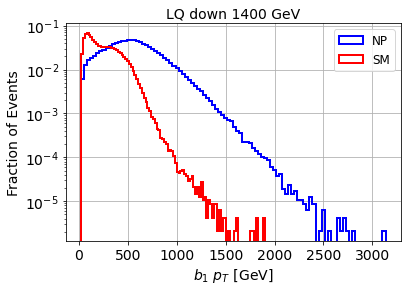

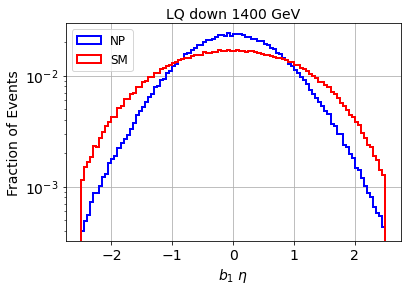

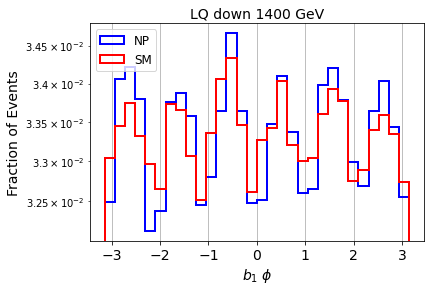

In [9]:
weights = np.ones_like(b1_NP[:,0])/float(len(b1_NP[:,0]))
plt.hist(b1_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,0])/float(len(b1_SM[:,0]))
plt.hist(b1_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(b1_NP[:,1])/float(len(b1_NP[:,1]))
plt.hist(b1_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,1])/float(len(b1_SM[:,1]))
plt.hist(b1_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(b1_NP[:,2])/float(len(b1_NP[:,2]))
plt.hist(b1_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b1_SM[:,2])/float(len(b1_SM[:,2]))
plt.hist(b1_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_1$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

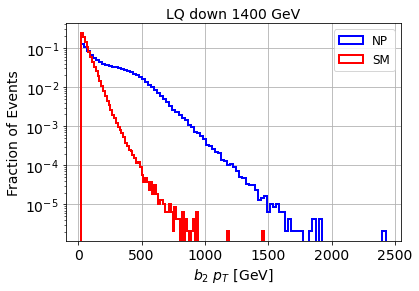

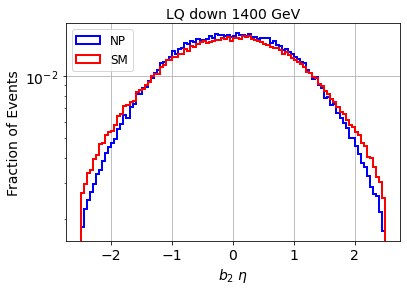

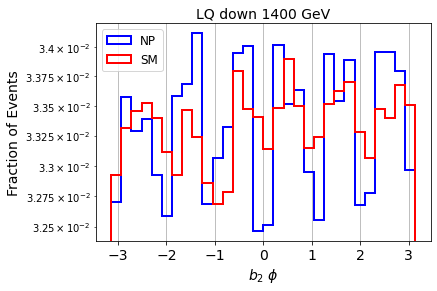

In [10]:
weights = np.ones_like(b2_NP[:,0])/float(len(b2_NP[:,0]))
plt.hist(b2_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,0])/float(len(b2_SM[:,0]))
plt.hist(b2_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(b2_NP[:,1])/float(len(b2_NP[:,1]))
plt.hist(b2_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,1])/float(len(b2_SM[:,1]))
plt.hist(b2_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(b2_NP[:,2])/float(len(b2_NP[:,2]))
plt.hist(b2_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(b2_SM[:,2])/float(len(b2_SM[:,2]))
plt.hist(b2_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$b_2$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

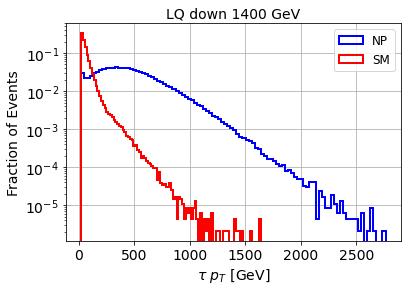

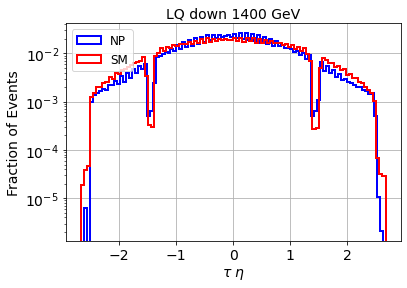

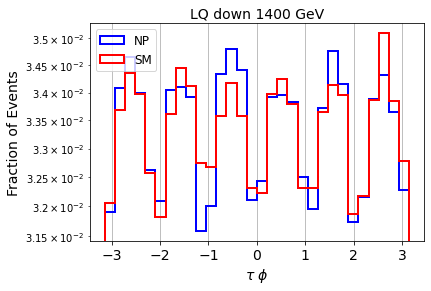

In [11]:
weights = np.ones_like(tau_NP[:,0])/float(len(tau_NP[:,0]))
plt.hist(tau_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,0])/float(len(tau_SM[:,0]))
plt.hist(tau_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(tau_NP[:,1])/float(len(tau_NP[:,1]))
plt.hist(tau_NP[:,1], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,1])/float(len(tau_SM[:,1]))
plt.hist(tau_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $\eta$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(tau_NP[:,2])/float(len(tau_NP[:,2]))
plt.hist(tau_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(tau_SM[:,2])/float(len(tau_SM[:,2]))
plt.hist(tau_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel(r"$\tau$ $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

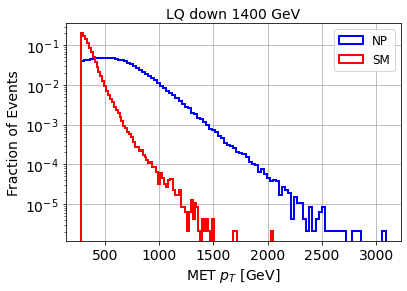

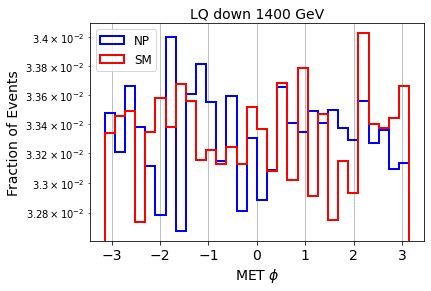

In [12]:
weights = np.ones_like(MET_NP[:,0])/float(len(MET_NP[:,0]))
plt.hist(MET_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(MET_SM[:,0])/float(len(MET_SM[:,0]))
plt.hist(MET_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("MET $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()


weights = np.ones_like(MET_NP[:,2])/float(len(MET_NP[:,2]))
plt.hist(MET_NP[:,2], weights=weights, bins=30, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(MET_SM[:,2])/float(len(MET_SM[:,2]))
plt.hist(MET_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("MET $\phi$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

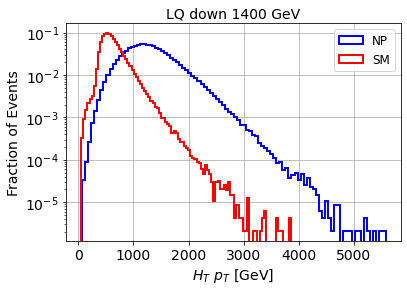

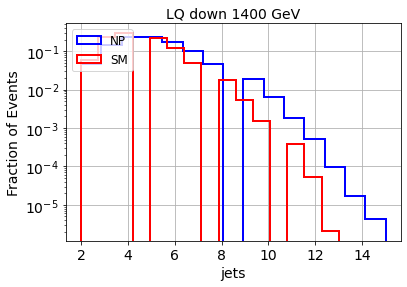

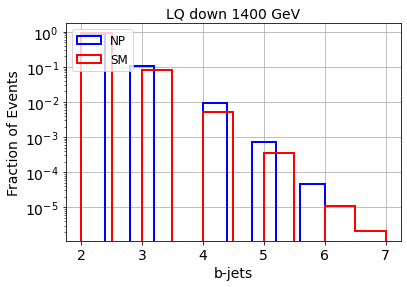

In [13]:
weights = np.ones_like(hadinfo_NP[:,0])/float(len(hadinfo_NP[:,0]))
plt.hist(hadinfo_NP[:,0], weights=weights, bins=100, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,0])/float(len(hadinfo_SM[:,0]))
plt.hist(hadinfo_SM[:,0], weights=weights, bins=100, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("$H_T$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right',fontsize=12)
plt.show()



weights = np.ones_like(hadinfo_NP[:,1])/float(len(hadinfo_NP[:,1]))
plt.hist(hadinfo_NP[:,1], weights=weights, bins=15, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,1])/float(len(hadinfo_SM[:,1]))
plt.hist(hadinfo_SM[:,1], weights=weights, bins=15, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()



weights = np.ones_like(hadinfo_NP[:,2])/float(len(hadinfo_NP[:,2]))
plt.hist(hadinfo_NP[:,2], weights=weights, bins=10, lw=2, edgecolor='blue', histtype='step', label="NP")
weights = np.ones_like(hadinfo_SM[:,2])/float(len(hadinfo_SM[:,2]))
plt.hist(hadinfo_SM[:,2], weights=weights, bins=10, lw=2, edgecolor='red', histtype='step', label="SM")

plt.grid()  # Add grid lines
plt.title(title,fontsize=14)  # Titles etc
plt.xlabel("b-jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left',fontsize=12)
plt.show()

### Train-test-val Dataset

In [14]:
# to normalize
scaler = preprocessing.MinMaxScaler()

# DATA WITH UNCERTAINTIES
err_pt_tau_SM = 0.1
err_pt_tau_NP = 0.

tau_SM_pt_upB = [i*(1. + err_pt_tau_SM) for i in tau_SM[:,0]]
tau_NP_pt_upB = [i*(1. + err_pt_tau_NP) for i in tau_NP[:,0]]

tau_SM_pt_downB = [i*(1. - err_pt_tau_SM) for i in tau_SM[:,0]]
tau_NP_pt_downB = [i*(1. - err_pt_tau_NP) for i in tau_NP[:,0]]



df = pd.DataFrame()

df['b1-pt']= np.concatenate([b1_SM[:,0],b1_NP[:,0]])
df['b1-eta']= np.concatenate([b1_SM[:,1],b1_NP[:,1]])
df['b1-phi']= np.concatenate([b1_SM[:,2],b1_NP[:,2]])
# remove the used data
del b1_SM
del b1_NP

df['b2-pt']= np.concatenate([b2_SM[:,0],b2_NP[:,0]])
df['b2-eta']= np.concatenate([b2_SM[:,1],b2_NP[:,1]])
df['b2-phi']= np.concatenate([b2_SM[:,2],b2_NP[:,2]])
# remove the used dat
del b2_SM
del b2_NP

df['tau-pt']= np.concatenate([tau_SM[:,0],tau_NP[:,0]])
df['tau-eta']= np.concatenate([tau_SM[:,1],tau_NP[:,1]])
df['tau-phi']= np.concatenate([tau_SM[:,2],tau_NP[:,2]])
# remove the used data
del tau_SM
del tau_NP

df['MET-pt']= np.concatenate([MET_SM[:,0],MET_NP[:,0]])
df['MET-phi']= np.concatenate([MET_SM[:,2],MET_NP[:,2]])
# remove the used data
del MET_SM
del MET_NP

df['HT-pt']= np.concatenate([hadinfo_SM[:,0],hadinfo_NP[:,0]])
df['num-jets']= np.concatenate([hadinfo_SM[:,1],hadinfo_NP[:,1]])
df['num-bjets']= np.concatenate([hadinfo_SM[:,2],hadinfo_NP[:,2]])
# remove the used data
del hadinfo_SM
del hadinfo_NP

df['Y'] = np.concatenate([np.zeros(num_data_SM),np.ones(num_data_NP)])



#df_upB = pd.DataFrame()
df_upB = df.copy()
df_upB['tau-pt'] = np.concatenate([tau_SM_pt_upB,tau_NP_pt_upB])
del tau_SM_pt_upB
del tau_NP_pt_upB

df_downB = df.copy()
df_downB['tau-pt'] = np.concatenate([tau_SM_pt_downB,tau_NP_pt_downB])
del tau_SM_pt_downB
del tau_NP_pt_downB


# NORMALIZE
df = scaler.fit_transform(df)
df = pd.DataFrame(df,columns=['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets','Y'])


# print df to see the data
print(df)


# X and Y for the classifier
X_mon = df[['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets']].values
y_mon = df[['Y']].values


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)


X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)


print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

           b1-pt    b1-eta    b1-phi     b2-pt    b2-eta    b2-phi    tau-pt  \
0       0.007833  0.639656  0.978199  0.002249  0.475990  0.432368  0.005743   
1       0.017570  0.184874  0.496181  0.018599  0.532013  0.058243  0.001920   
2       0.031700  0.628651  0.564290  0.008800  0.573629  0.929822  0.010617   
3       0.075341  0.276110  0.337842  0.053318  0.332533  0.454806  0.024983   
4       0.037100  0.747299  0.141948  0.009041  0.855342  0.447804  0.005958   
...          ...       ...       ...       ...       ...       ...       ...   
949025  0.220623  0.463585  0.994112  0.103921  0.659464  0.791852  0.041146   
949026  0.139062  0.386755  0.936665  0.124648  0.568227  0.972788  0.296502   
949027  0.178839  0.543217  0.469128  0.015559  0.612445  0.010344  0.022070   
949028  0.198845  0.535014  0.984564  0.043665  0.265906  0.633195  0.121579   
949029  0.046058  0.720888  0.234882  0.017695  0.049020  0.952896  0.086603   

         tau-eta   tau-phi    MET-pt   

In [15]:
# DATA WITH UNCERTAINTIES +1sigma

# NORMALIZE
df_upB = scaler.fit_transform(df_upB)
df_upB = pd.DataFrame(df_upB,columns=['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets','Y'])


# X and Y for the classifier
X_monupB = df_upB[['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets']].values
y_monupB = df_upB[['Y']].values

del df_upB

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_monupB_aux, X_monupB_test, y_monupB_aux, y_monupB_test = train_test_split(X_monupB,
                                                                y_monupB,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_monupB,
                                                                shuffle=True)


X_monupB_train, X_monupB_val, y_monupB_train, y_monupB_val = train_test_split(X_monupB_aux,
                                                                  y_monupB_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_monupB_aux,
                                                                  shuffle=True)


print('')
print('X_monupB_train : ', X_monupB_train.shape)
print('y_monupB_train : ', y_monupB_train.shape)
print('X_monupB_val : ', X_monupB_val.shape)
print('y_monupB_val : ', y_monupB_val.shape)
print('X_monupB_test : ', X_monupB_test.shape)
print('y_monupB_test : ', y_monupB_test.shape)
print('')


X_monupB_train :  (474514, 14)
y_monupB_train :  (474514, 1)
X_monupB_val :  (158172, 14)
y_monupB_val :  (158172, 1)
X_monupB_test :  (316344, 14)
y_monupB_test :  (316344, 1)



In [16]:
# DATA WITH UNCERTAINTIES -1sigma

# NORMALIZE
df_downB = scaler.fit_transform(df_downB)
df_downB = pd.DataFrame(df_downB,columns=['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets','Y'])


# X and Y for the classifier
X_mondownB = df_downB[['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets']].values
y_mondownB = df_downB[['Y']].values

del df_downB

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mondownB_aux, X_mondownB_test, y_mondownB_aux, y_mondownB_test = train_test_split(X_mondownB,
                                                                y_mondownB,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mondownB,
                                                                shuffle=True)


X_mondownB_train, X_mondownB_val, y_mondownB_train, y_mondownB_val = train_test_split(X_mondownB_aux,
                                                                  y_mondownB_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mondownB_aux,
                                                                  shuffle=True)


print('')
print('X_mondownB_train : ', X_mondownB_train.shape)
print('y_mondownB_train : ', y_mondownB_train.shape)
print('X_mondownB_val : ', X_mondownB_val.shape)
print('y_mondownB_val : ', y_mondownB_val.shape)
print('X_mondownB_test : ', X_mondownB_test.shape)
print('y_mondownB_test : ', y_mondownB_test.shape)
print('')


X_mondownB_train :  (474514, 14)
y_mondownB_train :  (474514, 1)
X_mondownB_val :  (158172, 14)
y_mondownB_val :  (158172, 1)
X_mondownB_test :  (316344, 14)
y_mondownB_test :  (316344, 1)



### XGBoost (per-event)

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.61059	validation_1-logloss:0.61055
[1]	validation_0-logloss:0.54280	validation_1-logloss:0.54288
[2]	validation_0-logloss:0.48619	validation_1-logloss:0.48621
[3]	validation_0-logloss:0.43839	validation_1-logloss:0.43829
[4]	validation_0-logloss:0.39765	validation_1-logloss:0.39749
[5]	validation_0-logloss:0.36239	validation_1-logloss:0.36229
[6]	validation_0-logloss:0.33201	validation_1-logloss:0.33193
[7]	validation_0-logloss:0.30544	validation_1-logloss:0.30545
[8]	validation_0-logloss:0.28217	validation_1-logloss:0.28222
[9]	validation_0-logloss:0.26170	validation_1-logloss:0.26173
[10]	validation_0-logloss:0.24372	validation_1-logloss:0.24374
[11]	validation_0-logloss:0.22767	validation_1-logloss:0.22774
[12]	validation_0-logloss:0.21359	validation_1-logloss:0.21368
[13]	validation_0-logloss:0.20100	validation_1-logloss:0.20110
[14]	validation_0-logloss:0.18982	validation_1-logloss:0.18996
[15]	validation_0-logloss:0.17980	validation_1-logloss:0.17998
[1

[130]	validation_0-logloss:0.07644	validation_1-logloss:0.08116
[131]	validation_0-logloss:0.07640	validation_1-logloss:0.08114
[132]	validation_0-logloss:0.07634	validation_1-logloss:0.08112
[133]	validation_0-logloss:0.07623	validation_1-logloss:0.08105
[134]	validation_0-logloss:0.07619	validation_1-logloss:0.08104
[135]	validation_0-logloss:0.07612	validation_1-logloss:0.08099
[136]	validation_0-logloss:0.07604	validation_1-logloss:0.08095
[137]	validation_0-logloss:0.07594	validation_1-logloss:0.08091
[138]	validation_0-logloss:0.07591	validation_1-logloss:0.08089
[139]	validation_0-logloss:0.07580	validation_1-logloss:0.08084
[140]	validation_0-logloss:0.07579	validation_1-logloss:0.08084
[141]	validation_0-logloss:0.07575	validation_1-logloss:0.08082
[142]	validation_0-logloss:0.07573	validation_1-logloss:0.08082
[143]	validation_0-logloss:0.07570	validation_1-logloss:0.08080
[144]	validation_0-logloss:0.07567	validation_1-logloss:0.08080
[145]	validation_0-logloss:0.07564	valid

[259]	validation_0-logloss:0.06407	validation_1-logloss:0.07198
[260]	validation_0-logloss:0.06348	validation_1-logloss:0.07143
[261]	validation_0-logloss:0.06345	validation_1-logloss:0.07143
[262]	validation_0-logloss:0.06343	validation_1-logloss:0.07143
[263]	validation_0-logloss:0.06338	validation_1-logloss:0.07141
[264]	validation_0-logloss:0.06332	validation_1-logloss:0.07138
[265]	validation_0-logloss:0.06330	validation_1-logloss:0.07138
[266]	validation_0-logloss:0.06328	validation_1-logloss:0.07138
[267]	validation_0-logloss:0.06326	validation_1-logloss:0.07138
[268]	validation_0-logloss:0.06319	validation_1-logloss:0.07135
[269]	validation_0-logloss:0.06316	validation_1-logloss:0.07135
[270]	validation_0-logloss:0.06309	validation_1-logloss:0.07133
[271]	validation_0-logloss:0.06299	validation_1-logloss:0.07127
[272]	validation_0-logloss:0.06297	validation_1-logloss:0.07127
[273]	validation_0-logloss:0.06276	validation_1-logloss:0.07110
[274]	validation_0-logloss:0.06273	valid

[388]	validation_0-logloss:0.05717	validation_1-logloss:0.06803
[389]	validation_0-logloss:0.05714	validation_1-logloss:0.06803
[390]	validation_0-logloss:0.05713	validation_1-logloss:0.06802
[391]	validation_0-logloss:0.05712	validation_1-logloss:0.06803
[392]	validation_0-logloss:0.05711	validation_1-logloss:0.06802
[393]	validation_0-logloss:0.05708	validation_1-logloss:0.06801
[394]	validation_0-logloss:0.05704	validation_1-logloss:0.06800
[395]	validation_0-logloss:0.05680	validation_1-logloss:0.06779
[396]	validation_0-logloss:0.05679	validation_1-logloss:0.06779
[397]	validation_0-logloss:0.05676	validation_1-logloss:0.06780
[398]	validation_0-logloss:0.05672	validation_1-logloss:0.06779
[399]	validation_0-logloss:0.05671	validation_1-logloss:0.06779
[400]	validation_0-logloss:0.05670	validation_1-logloss:0.06779
[401]	validation_0-logloss:0.05666	validation_1-logloss:0.06778
[402]	validation_0-logloss:0.05663	validation_1-logloss:0.06778
[403]	validation_0-logloss:0.05639	valid

[517]	validation_0-logloss:0.05317	validation_1-logloss:0.06642
[518]	validation_0-logloss:0.05316	validation_1-logloss:0.06642
[519]	validation_0-logloss:0.05314	validation_1-logloss:0.06643
[520]	validation_0-logloss:0.05310	validation_1-logloss:0.06640
[521]	validation_0-logloss:0.05308	validation_1-logloss:0.06640
[522]	validation_0-logloss:0.05304	validation_1-logloss:0.06639
[523]	validation_0-logloss:0.05301	validation_1-logloss:0.06640
[524]	validation_0-logloss:0.05300	validation_1-logloss:0.06640
[525]	validation_0-logloss:0.05300	validation_1-logloss:0.06640
[526]	validation_0-logloss:0.05298	validation_1-logloss:0.06640
[527]	validation_0-logloss:0.05295	validation_1-logloss:0.06640
[528]	validation_0-logloss:0.05284	validation_1-logloss:0.06633
[529]	validation_0-logloss:0.05282	validation_1-logloss:0.06633
[530]	validation_0-logloss:0.05280	validation_1-logloss:0.06633
[531]	validation_0-logloss:0.05278	validation_1-logloss:0.06633
[532]	validation_0-logloss:0.05276	valid

[646]	validation_0-logloss:0.04916	validation_1-logloss:0.06478
[647]	validation_0-logloss:0.04914	validation_1-logloss:0.06478
[648]	validation_0-logloss:0.04914	validation_1-logloss:0.06478
[649]	validation_0-logloss:0.04913	validation_1-logloss:0.06478
[650]	validation_0-logloss:0.04912	validation_1-logloss:0.06479
[651]	validation_0-logloss:0.04910	validation_1-logloss:0.06479
[652]	validation_0-logloss:0.04910	validation_1-logloss:0.06479
[653]	validation_0-logloss:0.04908	validation_1-logloss:0.06479
[654]	validation_0-logloss:0.04908	validation_1-logloss:0.06479
[655]	validation_0-logloss:0.04907	validation_1-logloss:0.06479
[656]	validation_0-logloss:0.04906	validation_1-logloss:0.06479
[657]	validation_0-logloss:0.04905	validation_1-logloss:0.06479
[658]	validation_0-logloss:0.04904	validation_1-logloss:0.06479
[659]	validation_0-logloss:0.04902	validation_1-logloss:0.06479
[660]	validation_0-logloss:0.04884	validation_1-logloss:0.06460
[661]	validation_0-logloss:0.04882	valid

[775]	validation_0-logloss:0.04587	validation_1-logloss:0.06353
[776]	validation_0-logloss:0.04585	validation_1-logloss:0.06352
[777]	validation_0-logloss:0.04584	validation_1-logloss:0.06352
[778]	validation_0-logloss:0.04579	validation_1-logloss:0.06349
[779]	validation_0-logloss:0.04576	validation_1-logloss:0.06348
[780]	validation_0-logloss:0.04571	validation_1-logloss:0.06345
[781]	validation_0-logloss:0.04570	validation_1-logloss:0.06345
[782]	validation_0-logloss:0.04568	validation_1-logloss:0.06345
[783]	validation_0-logloss:0.04566	validation_1-logloss:0.06345
[784]	validation_0-logloss:0.04564	validation_1-logloss:0.06345
[785]	validation_0-logloss:0.04554	validation_1-logloss:0.06337
[786]	validation_0-logloss:0.04552	validation_1-logloss:0.06337
[787]	validation_0-logloss:0.04550	validation_1-logloss:0.06335
[788]	validation_0-logloss:0.04548	validation_1-logloss:0.06335
[789]	validation_0-logloss:0.04546	validation_1-logloss:0.06335
[790]	validation_0-logloss:0.04544	valid

[904]	validation_0-logloss:0.04328	validation_1-logloss:0.06292
[905]	validation_0-logloss:0.04327	validation_1-logloss:0.06292
[906]	validation_0-logloss:0.04325	validation_1-logloss:0.06292
[907]	validation_0-logloss:0.04324	validation_1-logloss:0.06293
[908]	validation_0-logloss:0.04322	validation_1-logloss:0.06291
[909]	validation_0-logloss:0.04319	validation_1-logloss:0.06292
[910]	validation_0-logloss:0.04318	validation_1-logloss:0.06292
[911]	validation_0-logloss:0.04316	validation_1-logloss:0.06293
[912]	validation_0-logloss:0.04314	validation_1-logloss:0.06293
[913]	validation_0-logloss:0.04312	validation_1-logloss:0.06292
[914]	validation_0-logloss:0.04310	validation_1-logloss:0.06292
[915]	validation_0-logloss:0.04308	validation_1-logloss:0.06294
[916]	validation_0-logloss:0.04308	validation_1-logloss:0.06293
[917]	validation_0-logloss:0.04306	validation_1-logloss:0.06294
[918]	validation_0-logloss:0.04303	validation_1-logloss:0.06294
[919]	validation_0-logloss:0.04303	valid

[1032]	validation_0-logloss:0.04093	validation_1-logloss:0.06268
[1033]	validation_0-logloss:0.04091	validation_1-logloss:0.06268
[1034]	validation_0-logloss:0.04089	validation_1-logloss:0.06269
[1035]	validation_0-logloss:0.04088	validation_1-logloss:0.06269
[1036]	validation_0-logloss:0.04087	validation_1-logloss:0.06269
[1037]	validation_0-logloss:0.04087	validation_1-logloss:0.06269
[1038]	validation_0-logloss:0.04085	validation_1-logloss:0.06269
[1039]	validation_0-logloss:0.04084	validation_1-logloss:0.06269
[1040]	validation_0-logloss:0.04084	validation_1-logloss:0.06269
[1041]	validation_0-logloss:0.04083	validation_1-logloss:0.06269
[1042]	validation_0-logloss:0.04082	validation_1-logloss:0.06269
[1043]	validation_0-logloss:0.04082	validation_1-logloss:0.06269
[1044]	validation_0-logloss:0.04081	validation_1-logloss:0.06269
[1045]	validation_0-logloss:0.04079	validation_1-logloss:0.06269
[1046]	validation_0-logloss:0.04078	validation_1-logloss:0.06270
[1047]	validation_0-loglo

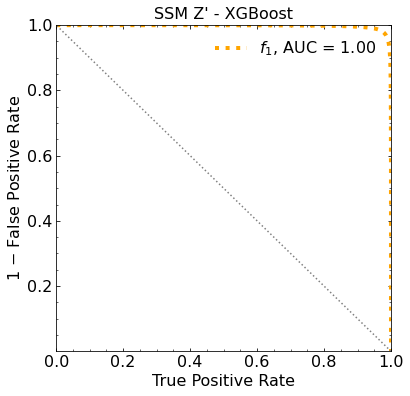

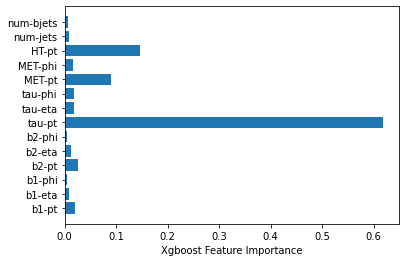

In [17]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"SSM Z' - XGBoost",fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()




# THIS IS THE DEFAULT FEATURE IMPORTANCE: gain
feature_names = np.array(['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets'])
plt.barh(feature_names, classifier.feature_importances_)
plt.xlabel("Xgboost Feature Importance")
plt.show()

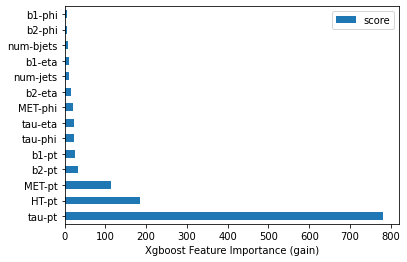

In [18]:
keys = np.array(['b1-pt','b1-eta','b1-phi','b2-pt','b2-eta','b2-phi','tau-pt','tau-eta','tau-phi','MET-pt','MET-phi','HT-pt','num-jets','num-bjets'])

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh') ## plot top 20 features
plt.xlabel("Xgboost Feature Importance (gain)")
plt.show()

Classification score:


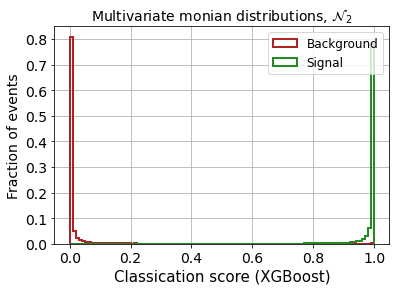

ROC AUC:        0.9973230659896206
ROC AUC upB:    0.9969880602840481
ROC AUC downB:  0.9976407197818691


In [19]:
# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('Multivariate monian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2monian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()




# DATA WITH UNCERTAINTIES +1sigma

# PREDICTIONS
y_pred_xgupB = classifier.predict_proba(X_monupB_test).T[1]


# ROC
fpr_mon_xgupB, tpr_mon_xgupB, _ = roc_curve(y_monupB_test, y_pred_xgupB)
roc_auc_xgupB = auc(fpr_mon_xgupB, tpr_mon_xgupB)

# Outputs for validation data set

pred_XG_SMupB = []
pred_XG_NPupB = []

for i in range(len(y_monupB_test)):
    if y_monupB_test[i] == 0:
        pred_XG_SMupB.append(y_pred_xgupB[i])
    else:
        pred_XG_NPupB.append(y_pred_xgupB[i])




# DATA WITH UNCERTAINTIES -1sigma

# PREDICTIONS
y_pred_xgdownB = classifier.predict_proba(X_mondownB_test).T[1]

# ROC
fpr_mon_xgdownB, tpr_mon_xgdownB, _ = roc_curve(y_mondownB_test, y_pred_xgdownB)
roc_auc_xgdownB = auc(fpr_mon_xgdownB, tpr_mon_xgdownB)

# Outputs for validation data set

pred_XG_SMdownB = []
pred_XG_NPdownB = []

for i in range(len(y_mondownB_test)):
    if y_mondownB_test[i] == 0:
        pred_XG_SMdownB.append(y_pred_xgdownB[i])
    else:
        pred_XG_NPdownB.append(y_pred_xgdownB[i])
        
        
        
print('ROC AUC:       ',roc_auc_xg)
print('ROC AUC upB:   ',roc_auc_xgupB)
print('ROC AUC downB: ',roc_auc_xgdownB)

In [20]:
# we choose the worst one to be conservative

## METHODS

### 0. Ensembles characteristics

In [21]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 2000

# number of expected background events per ensemble
B_expected = round(300 * totalcrossSM)    # luminosity * cross * aceptance
print('B_expected: ', B_expected)

print('S_expected: ', round(300 * crossfidNP))    # luminosity * cross * aceptance
S_expected = [1,3,5,10,15,20,25]



# SOME USEFUL DERIVATED PARAMETERS:

# S/\sqrt{B}
SB_ratio = [ S_expected[iii]/(1.*B_expected) for iii in range(len(S_expected)) ]

# S/\sqrt{B}
SsqrtB = [ S_expected[iii]/(B_expected)**0.5 for iii in range(len(S_expected)) ]

B_expected:  4596
S_expected:  20


In [22]:
300 * crossfidNP

20.062086905838697

### 1. BIN LOG LIKELIHOOD

In [23]:
MIN_EVS = 5

# Les't find the number of possible ensembles
N_ensembles_back = int(len(pred_XG_SM) / B_expected)
N_events_back = N_ensembles_back * B_expected


for bin_it in range(10,100):
    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM[:N_events_back]], bins=(bin_it), range = [[0,1]])

    if min(hist_back) < MIN_EVS * N_ensembles_back:
        print('At least ' + str(MIN_EVS) + ' B events per bin, range = [[0,1]]:')
        print('# bins: ',bin_it,'NO ok')
        print(min(hist_back/N_ensembles_back))
        break
        
print('')

for bin_it in range(10,100):
    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM[:N_events_back]], bins=(bin_it), range = [[min(pred_XG_SM[:N_events_back]),max(pred_XG_SM[:N_events_back])]])

    if min(hist_back) < MIN_EVS * N_ensembles_back:
        print('At least ' + str(MIN_EVS) + ' B events per bin, range = [[min(B),max(B)]]:')
        print('# bins: ',bin_it,'NO ok')
        print(min(hist_back/N_ensembles_back))
        break

At least 5 B events per bin, range = [[0,1]]:
# bins:  31 NO ok
4.970588235294118

At least 5 B events per bin, range = [[min(B),max(B)]]:
# bins:  31 NO ok
4.970588235294118


B_expected:  4596
S_expected:  1
S/$\sqrt{B}$:  0.014750610319128192

 If  919  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take a bit... 



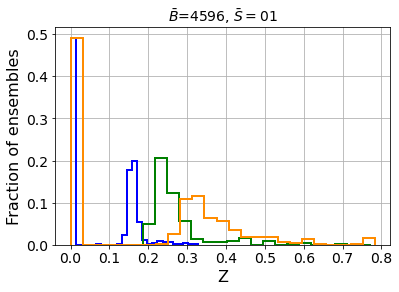

Z_bins_16bins:  0.13914197111619014
Z_bins_16bins_std:  0.08589799937169126
Z_bins_50bins:  0.1986287601286219
Z_bins_50bins_std:  0.1473170628077959
Z_bins_100bins:  0.26225645682864596
Z_bins_100bins_std:  0.20787977713208167

 -------------------------------- 

B_expected:  4596
S_expected:  3
S/$\sqrt{B}$:  0.04425183095738457

 If  919  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take a bit... 



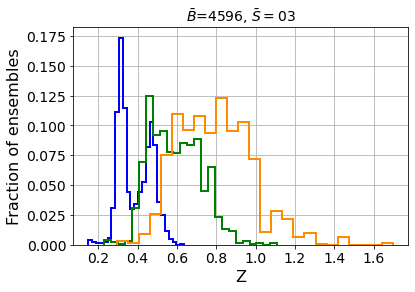

Z_bins_16bins:  0.37076015453794414
Z_bins_16bins_std:  0.08236890358800823
Z_bins_50bins:  0.582369901300275
Z_bins_50bins_std:  0.13033119502416796
Z_bins_100bins:  0.7806612927828696
Z_bins_100bins_std:  0.18741806980000436

 -------------------------------- 

B_expected:  4596
S_expected:  5
S/$\sqrt{B}$:  0.07375305159564095

 If  921  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take a bit... 



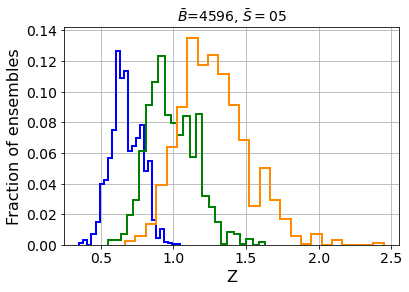

Z_bins_16bins:  0.6629543523012013
Z_bins_16bins_std:  0.10350182855138773
Z_bins_50bins:  0.9674461592293903
Z_bins_50bins_std:  0.1641903001298503
Z_bins_100bins:  1.248965875654961
Z_bins_100bins_std:  0.23374172411283403

 -------------------------------- 

B_expected:  4596
S_expected:  10
S/$\sqrt{B}$:  0.1475061031912819

 If  921  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take a bit... 



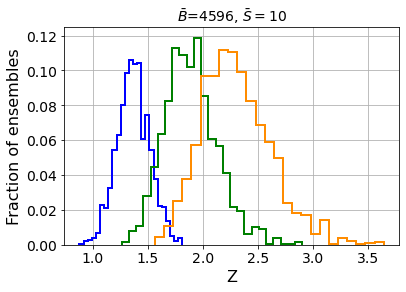

Z_bins_16bins:  1.3658602738339862
Z_bins_16bins_std:  0.14777416099651888
Z_bins_50bins:  1.87839218357405
Z_bins_50bins_std:  0.2424708475147794
Z_bins_100bins:  2.28033619197187
Z_bins_100bins_std:  0.31732611362196383

 -------------------------------- 

B_expected:  4596
S_expected:  15
S/$\sqrt{B}$:  0.22125915478692287

 If  923  =  279    then the proposed range has to be extended
n_ensembles (actual):  1777

 This may take a bit... 



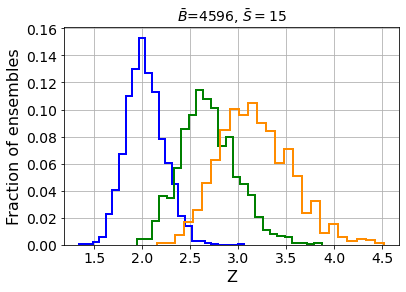

Z_bins_16bins:  2.017985818637354
Z_bins_16bins_std:  0.19543954671855376
Z_bins_50bins:  2.6741822478975052
Z_bins_50bins_std:  0.2953955198819948
Z_bins_100bins:  3.143841393129306
Z_bins_100bins_std:  0.3741308405346195

 -------------------------------- 

B_expected:  4596
S_expected:  20
S/$\sqrt{B}$:  0.2950122063825638

 If  923  =  279    then the proposed range has to be extended
n_ensembles (actual):  1777

 This may take a bit... 



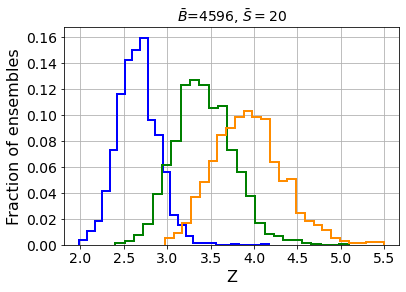

Z_bins_16bins:  2.6565726126881746
Z_bins_16bins_std:  0.23217747839574177
Z_bins_50bins:  3.401875993933759
Z_bins_50bins_std:  0.33726713676000397
Z_bins_100bins:  3.9204894333368876
Z_bins_100bins_std:  0.3985444952375992

 -------------------------------- 

B_expected:  4596
S_expected:  25
S/$\sqrt{B}$:  0.3687652579782048

 If  925  =  279    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take a bit... 



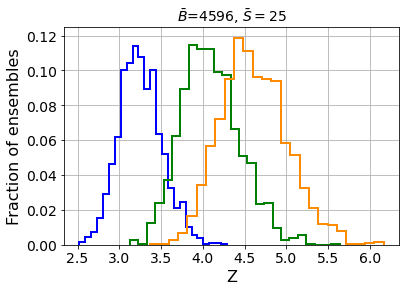

Z_bins_16bins:  3.2470249938529134
Z_bins_16bins_std:  0.25533784502004914
Z_bins_50bins:  4.083483254461342
Z_bins_50bins_std:  0.35039943424292924
Z_bins_100bins:  4.580416652557058
Z_bins_100bins_std:  0.3963740918294646

 -------------------------------- 



In [32]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################

store_Z_bins_XG_16bins = []
store_Z_bins_XG_50bins = []
store_Z_bins_XG_100bins = []

store_Z_bins_XG_16bins_std = []
store_Z_bins_XG_50bins_std = []
store_Z_bins_XG_100bins_std = []

# store_Z_bins_XG_16bins_noUnc = []
# store_Z_bins_XG_50bins_noUnc = []
# store_Z_bins_XG_100bins_noUnc = []

# store_Z_bins_XG_16bins_noUnc_std = []
# store_Z_bins_XG_50bins_noUnc_std = []
# store_Z_bins_XG_100bins_noUnc_std = []


indices_B = [i for i in range(len(pred_XG_SM))]
indices_S = [i for i in range(len(pred_XG_NP))]



#################
# Uncertainties #
#################
# Les't use an integer number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_events_back = N_ensembles_back * B_expected

# Let's find out the expected number of B and S events in each bin:

# 16 bins #

# (upB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMupB], bins=(16), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_upB = hist_back.T.ravel()/N_ensembles_back

# (downB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMdownB], bins=(16), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_downB = hist_back.T.ravel()/N_ensembles_back

back_prom_sig_16bins = abs(back_prom_upB-back_prom_downB)/2
# If a bins has no expected background events replace that zero for the minimum B_bin=/=0
# find the minimum
back_prom_sig_16bins_noceros = []
for i in range(len(back_prom_sig_16bins)):
    if back_prom_sig_16bins[i]!=0:
        back_prom_sig_16bins_noceros.append(back_prom_sig_16bins[i])

min_back = min(back_prom_sig_16bins_noceros)

# replace the zeros
for i in range(len(back_prom_sig_16bins)):
    if back_prom_sig_16bins[i]==0:
        back_prom_sig_16bins[i] = min_back
        
        
        
# 50 bins #

# (upB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMupB], bins=(50), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_upB = hist_back.T.ravel()/N_ensembles_back

# (downB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMdownB], bins=(50), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_downB = hist_back.T.ravel()/N_ensembles_back

back_prom_sig_50bins = abs(back_prom_upB-back_prom_downB)/2
# If a bins has no expected background events replace that zero for the minimum B_bin=/=0
# find the minimum
back_prom_sig_50bins_noceros = []
for i in range(len(back_prom_sig_50bins)):
    if back_prom_sig_50bins[i]!=0:
        back_prom_sig_50bins_noceros.append(back_prom_sig_50bins[i])

min_back = min(back_prom_sig_50bins_noceros)

# replace the zeros
for i in range(len(back_prom_sig_50bins)):
    if back_prom_sig_50bins[i]==0:
        back_prom_sig_50bins[i] = min_back
        
        
        
        
# 100 bins #

# (upB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMupB], bins=(100), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_upB = hist_back.T.ravel()/N_ensembles_back

# (downB type) #
# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SMdownB], bins=(100), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom_downB = hist_back.T.ravel()/N_ensembles_back

back_prom_sig_100bins = abs(back_prom_upB-back_prom_downB)/2
# If a bins has no expected background events replace that zero for the minimum B_bin=/=0
# find the minimum
back_prom_sig_100bins_noceros = []
for i in range(len(back_prom_sig_100bins)):
    if back_prom_sig_100bins[i]!=0:
        back_prom_sig_100bins_noceros.append(back_prom_sig_100bins[i])

min_back = min(back_prom_sig_100bins_noceros)

# replace the zeros
for i in range(len(back_prom_sig_100bins)):
    if back_prom_sig_100bins[i]==0:
        back_prom_sig_100bins[i] = min_back








for iii in range(len(S_expected)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    
    
    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######
    
    
    print('\n This may take a bit... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    Z_bins_16bins_aux = []
    Z_bins_50bins_aux = []
    Z_bins_100bins_aux = []
    
#     Z_bins_16bins_noUnc_aux = []
#     Z_bins_50bins_noUnc_aux = []
#     Z_bins_100bins_noUnc_aux = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            ran_ind_B = np.random.choice(indices_B, list_B_per_ensembles[bb])
            ran_ind_S = np.random.choice(indices_S, list_S_per_ensembles[bb])
            
            # estimate the variance in each bin as ~ (upB - downB)/2 
            
            pred_XG_SM_shuf = []
            
            pred_XG_NP_shuf = []
            
            for ill in ran_ind_B:
                pred_XG_SM_shuf.append(pred_XG_SM[ill])
                
            for ill in ran_ind_S:
                pred_XG_NP_shuf.append(pred_XG_NP[ill])
                
            
            
            ############
            # 16 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:       

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(16), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(16), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
#             ## then the signif Z^binned-Asimov without uncertainties:
#             Z_bins_16bins_noUnc = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

#             Z_bins_16bins_noUnc_aux.append(Z_bins_16bins_noUnc)
                    

            # then the signif Z^binned-Asimov with uncertainties in the background:

            B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_16bins**2))/((back_prom_sig_16bins**2)+back_prom) ))**0.5 )

            Z_bins_16bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + B_hat) ) ) - ( (back_prom**2/(back_prom_sig_16bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_16bins**2))) ) + sig_prom ) )**0.5

            Z_bins_16bins_aux.append(Z_bins_16bins_sig)
            
            
            
            
            
            ############
            # 50 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(50), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(50), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
#             ## then the signif Z^binned-Asimov without uncertainties:
#             Z_bins_50bins_noUnc = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

#             Z_bins_50bins_noUnc_aux.append(Z_bins_50bins_noUnc)
                    

            # then the signif Z^binned-Asimov with uncertainties in the background:

            B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_50bins**2))/((back_prom_sig_50bins**2)+back_prom) ))**0.5 )

            Z_bins_50bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + B_hat) ) ) - ( (back_prom**2/(back_prom_sig_50bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_50bins**2))) ) + sig_prom ) )**0.5

            Z_bins_50bins_aux.append(Z_bins_50bins_sig)
        
        
        
        
        
        
            ############
            # 100 bins #
            ############

            # Let's find out the expected number of B and S events in each bin:

            # bin the parameter space of all background events
            hist_back, binedges_back = np.histogramdd([pred_XG_SM_shuf], bins=(100), range = [[0,1]])
            # now divide by the number of possible ensembles
            back_prom = hist_back.T.ravel()

            # same for signal
            hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_shuf], bins=(100), range = [[0,1]])
            sig_prom = hist_sig.T.ravel()



            # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

            # find the minimum
            back_prom_noceros = []
            for i in range(len(back_prom)):
                if back_prom[i]!=0:
                    back_prom_noceros.append(back_prom[i])

            min_back = min(back_prom_noceros)

            # replace the zeros
            for i in range(len(back_prom)):
                if back_prom[i]==0:
                    back_prom[i] = min_back
                    
                    
                    
#             ## then the signif Z^binned-Asimov without uncertainties:
#             Z_bins_100bins_noUnc = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

#             Z_bins_100bins_noUnc_aux.append(Z_bins_100bins_noUnc)
                    

            # then the signif Z^binned-Asimov with uncertainties in the background:

            B_hat = 0.5* ( (back_prom-sig_prom) + ((back_prom+sig_prom)**2. - ( (4.*back_prom*sig_prom*(back_prom_sig_100bins**2))/((back_prom_sig_100bins**2)+back_prom) ))**0.5 )

            Z_bins_100bins_sig = abs( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + B_hat) ) ) - ( (back_prom**2/(back_prom_sig_100bins**2))*np.log(B_hat/back_prom) ) + ( (B_hat-back_prom)*(1+(back_prom/(back_prom_sig_100bins**2))) ) + sig_prom ) )**0.5

            Z_bins_100bins_aux.append(Z_bins_100bins_sig)
            
    
    
    
  
    # Histogram of q_muhats

    weights = np.ones_like(Z_bins_16bins_aux)/float(len(Z_bins_16bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_16bins_aux, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    weights = np.ones_like(Z_bins_50bins_aux)/float(len(Z_bins_50bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_50bins_aux, 25, weights=weights, histtype='step', color='green', linewidth=2)
    weights = np.ones_like(Z_bins_100bins_aux)/float(len(Z_bins_100bins_aux))
    nMIX, binsMIX, patchesMIX = plt.hist(Z_bins_100bins_aux, 25, weights=weights, histtype='step', color='darkorange', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Z",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()
    
    
    # 16 bins #
    # Remove nan if any
    Z_bins_16bins_aux = [x for x in Z_bins_16bins_aux if x == x]
    for jk in range(len(Z_bins_16bins_aux)):
        if Z_bins_16bins_aux[jk] < 0:
            Z_bins_16bins_aux[jk] = 0

    Z_bins_16bins = np.median(Z_bins_16bins_aux)   
    store_Z_bins_XG_16bins.append(Z_bins_16bins)
    
    Z_bins_16bins_std = np.std(Z_bins_16bins_aux)   
    store_Z_bins_XG_16bins_std.append(Z_bins_16bins_std)

    print('Z_bins_16bins: ', Z_bins_16bins)
    print('Z_bins_16bins_std: ', Z_bins_16bins_std)

    
#     # Remove nan if any
#     Z_bins_16bins_noUnc_aux = [x for x in Z_bins_16bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_16bins_noUnc_aux)):
#         if Z_bins_16bins_noUnc_aux[jk] < 0:
#             Z_bins_16bins_noUnc_aux[jk] = 0

#     Z_bins_16bins_noUnc = np.median(Z_bins_16bins_noUnc_aux)   
#     store_Z_bins_XG_16bins_noUnc.append(Z_bins_16bins_noUnc)
    
#     Z_bins_16bins_noUnc_std = np.std(Z_bins_16bins_noUnc_aux)   
#     store_Z_bins_XG_16bins_noUnc_std.append(Z_bins_16bins_noUnc_std)

#     print('Z_bins_16bins_noUnc: ', Z_bins_16bins_noUnc)
#     print('Z_bins_16bins_noUnc_std: ', Z_bins_16bins_noUnc_std)
    
    
    # 50 bins #
    # Remove nan if any
    Z_bins_50bins_aux = [x for x in Z_bins_50bins_aux if x == x]
    for jk in range(len(Z_bins_50bins_aux)):
        if Z_bins_50bins_aux[jk] < 0:
            Z_bins_50bins_aux[jk] = 0

    Z_bins_50bins = np.median(Z_bins_50bins_aux)   
    store_Z_bins_XG_50bins.append(Z_bins_50bins)
    
    Z_bins_50bins_std = np.std(Z_bins_50bins_aux)   
    store_Z_bins_XG_50bins_std.append(Z_bins_50bins_std)

    print('Z_bins_50bins: ', Z_bins_50bins)
    print('Z_bins_50bins_std: ', Z_bins_50bins_std)
    
    
#     # Remove nan if any
#     Z_bins_50bins_noUnc_aux = [x for x in Z_bins_50bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_50bins_noUnc_aux)):
#         if Z_bins_50bins_noUnc_aux[jk] < 0:
#             Z_bins_50bins_noUnc_aux[jk] = 0

#     Z_bins_50bins_noUnc = np.median(Z_bins_50bins_noUnc_aux)   
#     store_Z_bins_XG_50bins_noUnc.append(Z_bins_50bins_noUnc)
    
#     Z_bins_50bins_noUnc_std = np.std(Z_bins_50bins_noUnc_aux)   
#     store_Z_bins_XG_50bins_noUnc_std.append(Z_bins_50bins_noUnc_std)

#     print('Z_bins_50bins_noUnc: ', Z_bins_50bins_noUnc)
#     print('Z_bins_50bins_noUnc_std: ', Z_bins_50bins_noUnc_std)
    
    
    # 100 bins #
    # Remove nan if any
    Z_bins_100bins_aux = [x for x in Z_bins_100bins_aux if x == x]
    for jk in range(len(Z_bins_100bins_aux)):
        if Z_bins_100bins_aux[jk] < 0:
            Z_bins_100bins_aux[jk] = 0

    Z_bins_100bins = np.median(Z_bins_100bins_aux)   
    store_Z_bins_XG_100bins.append(Z_bins_100bins)
    
    Z_bins_100bins_std = np.std(Z_bins_100bins_aux)   
    store_Z_bins_XG_100bins_std.append(Z_bins_100bins_std)

    print('Z_bins_100bins: ', Z_bins_100bins)
    print('Z_bins_100bins_std: ', Z_bins_100bins_std)
    
    
#     # Remove nan if any
#     Z_bins_100bins_noUnc_aux = [x for x in Z_bins_100bins_noUnc_aux if x == x]
#     for jk in range(len(Z_bins_100bins_noUnc_aux)):
#         if Z_bins_100bins_noUnc_aux[jk] < 0:
#             Z_bins_100bins_noUnc_aux[jk] = 0

#     Z_bins_100bins_noUnc = np.median(Z_bins_100bins_noUnc_aux)   
#     store_Z_bins_XG_100bins_noUnc.append(Z_bins_100bins_noUnc)
    
#     Z_bins_100bins_noUnc_std = np.std(Z_bins_100bins_noUnc_aux)   
#     store_Z_bins_XG_100bins_noUnc_std.append(Z_bins_100bins_noUnc_std)

#     print('Z_bins_100bins_noUnc: ', Z_bins_100bins_noUnc)
#     print('Z_bins_100bins_noUnc_std: ', Z_bins_100bins_noUnc_std)

    print('\n -------------------------------- \n')

In [33]:
print(store_Z_bins_XG_16bins)
print(store_Z_bins_XG_50bins)
print(store_Z_bins_XG_100bins)

print(store_Z_bins_XG_16bins_std)
print(store_Z_bins_XG_50bins_std)
print(store_Z_bins_XG_100bins_std)

[0.13914197111619014, 0.37076015453794414, 0.6629543523012013, 1.3658602738339862, 2.017985818637354, 2.6565726126881746, 3.2470249938529134]
[0.1986287601286219, 0.582369901300275, 0.9674461592293903, 1.87839218357405, 2.6741822478975052, 3.401875993933759, 4.083483254461342]
[0.26225645682864596, 0.7806612927828696, 1.248965875654961, 2.28033619197187, 3.143841393129306, 3.9204894333368876, 4.580416652557058]
[0.08589799937169126, 0.08236890358800823, 0.10350182855138773, 0.14777416099651888, 0.19543954671855376, 0.23217747839574177, 0.25533784502004914]
[0.1473170628077959, 0.13033119502416796, 0.1641903001298503, 0.2424708475147794, 0.2953955198819948, 0.33726713676000397, 0.35039943424292924]
[0.20787977713208167, 0.18741806980000436, 0.23374172411283403, 0.31732611362196383, 0.3741308405346195, 0.3985444952375992, 0.3963740918294646]


In [43]:
store_Z_bins_XG_16bins = [0.13914197111619014, 0.37076015453794414, 0.6629543523012013, 1.3658602738339862, 2.017985818637354, 2.6565726126881746, 3.2470249938529134]
store_Z_bins_XG_50bins = [0.1986287601286219, 0.582369901300275, 0.9674461592293903, 1.87839218357405, 2.6741822478975052, 3.401875993933759, 4.083483254461342]
store_Z_bins_XG_100bins = [0.26225645682864596, 0.7806612927828696, 1.248965875654961, 2.28033619197187, 3.143841393129306, 3.9204894333368876, 4.580416652557058]

store_Z_bins_XG_16bins_std = [0.08589799937169126, 0.08236890358800823, 0.10350182855138773, 0.14777416099651888, 0.19543954671855376, 0.23217747839574177, 0.25533784502004914]
store_Z_bins_XG_50bins_std = [0.1473170628077959, 0.13033119502416796, 0.1641903001298503, 0.2424708475147794, 0.2953955198819948, 0.33726713676000397, 0.35039943424292924]
store_Z_bins_XG_100bins_std = [0.20787977713208167, 0.18741806980000436, 0.23374172411283403, 0.31732611362196383, 0.3741308405346195, 0.3985444952375992, 0.3963740918294646]

B_expected:  4596
S_expected:  1
S/$\sqrt{B}$:  0.014750610319128192


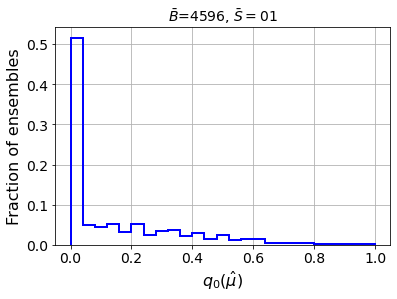

bins:  16
muhat mean:  0.10486346434677511
median q_muhat_16bins:  0.023519277462536792
Z_16bins:  0.15335996042819258
Z_16bins mu=0:  0.1512105157903187
std Z_16bins:  0.6617250267178065
std Z_16bins mu=0:  0.6717266187830279


 -------------------------------- 

B_expected:  4596
S_expected:  3
S/$\sqrt{B}$:  0.04425183095738457


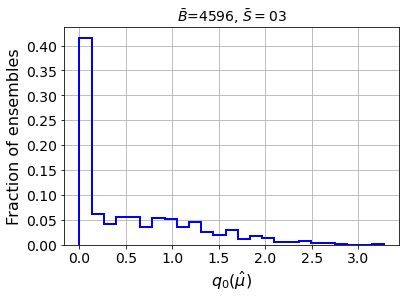

bins:  16
muhat mean:  -0.007626363344600603
median q_muhat_16bins:  0.3433751675951555
Z_16bins:  0.585982224640949
Z_16bins mu=0:  0.585982224640949
std Z_16bins:  0.5658537559806771
std Z_16bins mu=0:  0.5690093759453513


 -------------------------------- 

B_expected:  4596
S_expected:  5
S/$\sqrt{B}$:  0.07375305159564095


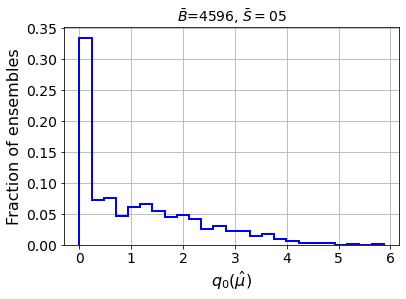

bins:  16
muhat mean:  -0.021700021297728123
median q_muhat_16bins:  0.839521894822246
Z_16bins:  0.9162542741085828
Z_16bins mu=0:  0.9162542741085828
std Z_16bins:  0.6212708891097941
std Z_16bins mu=0:  0.6301828022132907


 -------------------------------- 

B_expected:  4596
S_expected:  10
S/$\sqrt{B}$:  0.1475061031912819


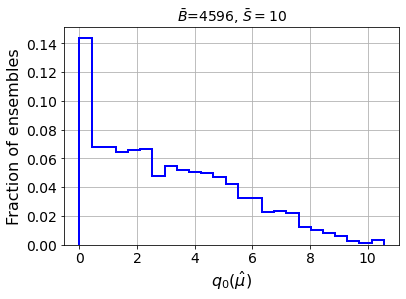

bins:  16
muhat mean:  -0.0044703922280632385
median q_muhat_16bins:  2.727147351474173
Z_16bins:  1.6514076878451829
Z_16bins mu=0:  1.6514076878451829
std Z_16bins:  0.7210435154290933
std Z_16bins mu=0:  0.7529530930957324


 -------------------------------- 

B_expected:  4596
S_expected:  15
S/$\sqrt{B}$:  0.22125915478692287


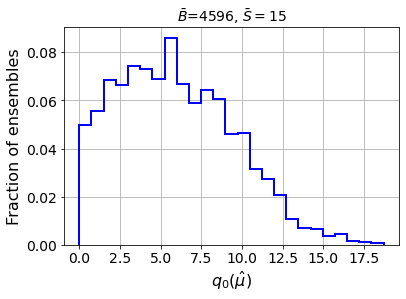

bins:  16
muhat mean:  -0.00367989124577589
median q_muhat_16bins:  5.596067521800933
Z_16bins:  2.3656008796500165
Z_16bins mu=0:  2.3656008796500165
std Z_16bins:  0.7567723944197821
std Z_16bins mu=0:  0.8109316621562535


 -------------------------------- 

B_expected:  4596
S_expected:  20
S/$\sqrt{B}$:  0.2950122063825638


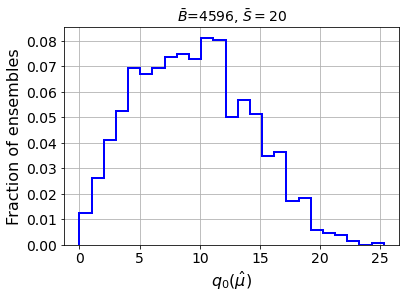

bins:  16
muhat mean:  -0.003464983976179152
median q_muhat_16bins:  9.34664927437539
Z_16bins:  3.0572290189606974
Z_16bins mu=0:  3.0572290189606974
std Z_16bins:  0.757814771206759
std Z_16bins mu=0:  0.8297863637688991


 -------------------------------- 

B_expected:  4596
S_expected:  25
S/$\sqrt{B}$:  0.3687652579782048


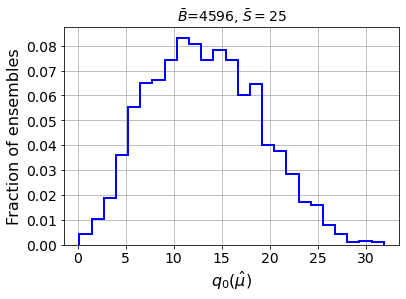

bins:  16
muhat mean:  0.008190950002263423
median q_muhat_16bins:  12.939625439818709
Z_16bins:  3.5971690869096924
Z_16bins mu=0:  3.597072645298134
std Z_16bins:  0.7862277995106716
std Z_16bins mu=0:  0.8656253675986761


 -------------------------------- 

[0.10486346434677511, -0.007626363344600603, -0.021700021297728123, -0.0044703922280632385, -0.00367989124577589, -0.003464983976179152, 0.008190950002263423]
[0.15335996042819258, 0.585982224640949, 0.9162542741085828, 1.6514076878451829, 2.3656008796500165, 3.0572290189606974, 3.5971690869096924]
[0.6617250267178065, 0.5658537559806771, 0.6212708891097941, 0.7210435154290933, 0.7567723944197821, 0.757814771206759, 0.7862277995106716]
[0.1512105157903187, 0.585982224640949, 0.9162542741085828, 1.6514076878451829, 2.3656008796500165, 3.0572290189606974, 3.597072645298134]
[0.6717266187830279, 0.5690093759453513, 0.6301828022132907, 0.7529530930957324, 0.8109316621562535, 0.8297863637688991, 0.8656253675986761]


In [25]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################

store_muhat_mean_16bins  = []

store_Z_bins_XG_16bins_q = []
store_Z_bins_XG_16bins_std = []

store_Z_bins_XG_16bins_mu0 = []
store_Z_bins_XG_16bins_std_mu0 = []




hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(16), range = [[0,1]])
bin_edges = binedges_back[0]
back_prom_16bins = hist_back.T.ravel() / (len(pred_XG_SM) / B_expected)

# find the minimum
back_prom_noceros = []
for i in range(len(back_prom_16bins)):
    if back_prom_16bins[i]!=0:
        back_prom_noceros.append(back_prom_16bins[i])

min_back = min(back_prom_noceros)

# replace the zeros
for i in range(len(back_prom_16bins)):
    if back_prom_16bins[i]==0:
        back_prom_16bins[i] = min_back
        
        






for iii in range(len(S_expected)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    

    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(16), range = [[0,1]])
    sig_prom_16bins = hist_sig.T.ravel() / (len(pred_XG_NP) / S_expected[iii])
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    muhat_selected_16bins_list = []
    q_muhat_16bins = []
    q_muhat_16bins_mu0 = []
    
    
    for its in range(n_ensembles):
        
        B_rand = np.random.poisson(int(B_expected))
        
        pred_XG_SM_shuf = np.random.choice(pred_XG_SM, size = B_rand, replace = False)
            
        pseudo_exp = pred_XG_SM_shuf


        ############
        # 16 bins #
        ############

        # Let's find out the expected number of B and S events in each bin:

        # bin the parameter space of all background events
        hist_N, binedges_N = np.histogramdd([pseudo_exp], bins=(16), range = [[0,1]])
        # now divide by the number of possible ensembles
        N_pseudo = hist_N.T.ravel()

        if min(N_pseudo) >= MIN_EVS:
                
            # approximation: mu_hat=0
            q_muhat_16bins_mu0.append( -2 * sum([( (ni * np.log( ((1.*si)+bi)/((0.*si)+bi) ) ) - ((1.*si)+bi) + ((0.*si)+bi) ) for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)]) )

                
            # compute mu_hat from implicit equation
            def f_mu_hat(mu_h, N_pseudo=N_pseudo, sig_prom_16bins=sig_prom_16bins, back_prom_16bins=back_prom_16bins):
                return sum ( [((ni*si) / ((mu_h*si) + bi)) - si for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)] )

        
            muhat_selected_16bins = fsolve(f_mu_hat,0)[0]
            
            muhat_selected_16bins_list.append(muhat_selected_16bins)

                
            if muhat_selected_16bins > 1:
                q_muhat_16bins.append( 0 )
                    
            elif muhat_selected_16bins > 0:
                q_muhat_16bins.append( -2 * sum([( (ni * np.log( ((1.*si)+bi)/((muhat_selected_16bins*si)+bi) ) ) - ((1.*si)+bi) + ((muhat_selected_16bins*si)+bi) ) for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)]) )

            else:
                q_muhat_16bins.append( -2 * sum([( (ni * np.log( ((1.*si)+bi)/((0.*si)+bi) ) ) - ((1.*si)+bi) + ((0.*si)+bi) ) for ni, si, bi in zip(N_pseudo, sig_prom_16bins, back_prom_16bins)]) )

            
            
            
        
        
    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_16bins)/float(len(q_muhat_16bins))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_16bins, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()

    
    

    # Finally calculate muhat_mean and Z_gaussian
    
    # 16 bins #
    # Remove nan if any
    q_muhat_16bins_mu0 = [x for x in q_muhat_16bins_mu0 if x == x]
    for jk in range(len(q_muhat_16bins_mu0)):
        if q_muhat_16bins_mu0[jk] < 0:
            q_muhat_16bins_mu0[jk] = 0

    q_muhat_16bins_median_mu0 = np.median(q_muhat_16bins_mu0)
    Z_16bins_mu0 = abs(q_muhat_16bins_median_mu0)**0.5
    store_Z_bins_XG_16bins_mu0.append(Z_16bins_mu0)
    
    q_muhat_16bins_std_mu0 = np.std(q_muhat_16bins_mu0)
    Z_16bins_std_mu0 = q_muhat_16bins_std_mu0/(2.*Z_16bins_mu0)
    store_Z_bins_XG_16bins_std_mu0.append(Z_16bins_std_mu0)
    

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_16bins = np.mean(muhat_selected_16bins_list)
    store_muhat_mean_16bins.append(muhat_mean_16bins)

    # Remove nan if any
    q_muhat_16bins = [x for x in q_muhat_16bins if x == x]
    for jk in range(len(q_muhat_16bins)):
        if q_muhat_16bins[jk] < 0:
            q_muhat_16bins[jk] = 0

    q_muhat_16bins_median = np.median(q_muhat_16bins)
    Z_16bins = abs(q_muhat_16bins_median)**0.5
    store_Z_bins_XG_16bins_q.append(Z_16bins)
    
    q_muhat_16bins_std = np.std(q_muhat_16bins)
    Z_16bins_std = q_muhat_16bins_std/(2.*Z_16bins)
    store_Z_bins_XG_16bins_std.append(Z_16bins_std)

    print('bins: ', 16)
    print('muhat mean: ', muhat_mean_16bins)
    print('median q_muhat_16bins: ', q_muhat_16bins_median)
    print('Z_16bins: ', Z_16bins)
    print('Z_16bins mu=0: ', Z_16bins_mu0)
    print('std Z_16bins: ', Z_16bins_std)
    print('std Z_16bins mu=0: ', Z_16bins_std_mu0)
    print('')
    
    

    print('\n -------------------------------- \n')
    

print(store_muhat_mean_16bins)

print(store_Z_bins_XG_16bins_q)
print(store_Z_bins_XG_16bins_std)

print(store_Z_bins_XG_16bins_mu0)
print(store_Z_bins_XG_16bins_std_mu0)

In [44]:
store_muhat_mean_16bins = [0.10486346434677511, -0.007626363344600603, -0.021700021297728123, -0.0044703922280632385, -0.00367989124577589, -0.003464983976179152, 0.008190950002263423]

store_Z_bins_XG_16bins_q = [0.15335996042819258, 0.585982224640949, 0.9162542741085828, 1.6514076878451829, 2.3656008796500165, 3.0572290189606974, 3.5971690869096924]
store_Z_bins_XG_16bins_std = [0.6617250267178065, 0.5658537559806771, 0.6212708891097941, 0.7210435154290933, 0.7567723944197821, 0.757814771206759, 0.7862277995106716]

store_Z_bins_XG_16bins_mu0 = [0.1512105157903187, 0.585982224640949, 0.9162542741085828, 1.6514076878451829, 2.3656008796500165, 3.0572290189606974, 3.597072645298134]
store_Z_bins_XG_16bins_std_mu0 = [0.6717266187830279, 0.5690093759453513, 0.6301828022132907, 0.7529530930957324, 0.8109316621562535, 0.8297863637688991, 0.8656253675986761]

In [45]:
store_Z_bins_XG_16bins_plus = [i+j for i, j in zip(store_Z_bins_XG_16bins, store_Z_bins_XG_16bins_std)]
store_Z_bins_XG_16bins_min = [i-j for i, j in zip(store_Z_bins_XG_16bins, store_Z_bins_XG_16bins_std)]

store_Z_bins_XG_50bins_plus = [i+j for i, j in zip(store_Z_bins_XG_50bins, store_Z_bins_XG_50bins_std)]
store_Z_bins_XG_50bins_min = [i-j for i, j in zip(store_Z_bins_XG_50bins, store_Z_bins_XG_50bins_std)]

store_Z_bins_XG_100bins_plus = [i+j for i, j in zip(store_Z_bins_XG_100bins, store_Z_bins_XG_100bins_std)]
store_Z_bins_XG_100bins_min = [i-j for i, j in zip(store_Z_bins_XG_100bins, store_Z_bins_XG_100bins_std)]

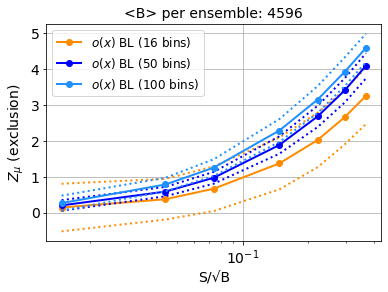

In [47]:
#########
# PLOTS #
#########

posX = []

for i in range(len(S_expected)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )


    
plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_16bins_plus, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_16bins_min, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins_plus, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins_min, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins, '-o', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins_plus, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins_min, ':', color='dodgerblue', lw=lw) 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### MLL KDE

#### KDE

/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
 14162.66273956 13189.16342271 12099.50877305 10881.66798392
  9558.99283231  8129.69205323  6616.76747971  5012.60375199
  3350.48940677  1663.0787758    -57.32683017 -1746.67491133]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


Background:  KernelDensity(bandwidth=0.005072980090653727, kernel='epanechnikov')


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
 13608.30883375 12739.81484459 11735.22685469 10615.81303403
  9377.21205003  8027.14627862  6575.52865996  5033.6794672
  3409.7505961   1730.51480067    13.63914135 -1718.30268616]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


Signal:  KernelDensity(bandwidth=0.005072980090653727, kernel='epanechnikov')


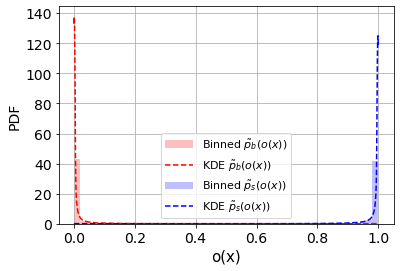

In [36]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs



# # FIND THE BANDWIDTH

#SM_bandwidth = 0.0127
#NP_bandwidth = 0.0127

bandwidth = np.logspace(-4.0, 0.05, 20)

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_SM[:20000]])
print('Background: ', grid.best_estimator_)

SM_bandwidth = grid.best_estimator_.bandwidth



kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_NP[:20000]])
print('Signal: ', grid.best_estimator_)

NP_bandwidth = grid.best_estimator_.bandwidth



# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg = KernelDensity(kernel="epanechnikov", bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
kde_sig = KernelDensity(kernel="epanechnikov", bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])



# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
#plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()

B_expected:  4596


<ipython-input-37-f9ea0c121e56>:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_16bins, '-ok', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)')
<ipython-input-37-f9ea0c121e56>:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_50bins, '-ok', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)')
<ipython-input-37-f9ea0c121e56>:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_XG_100bins, '-ok', color='red', lw=lw, label=r'$o(x)$ BL (100 bins)')


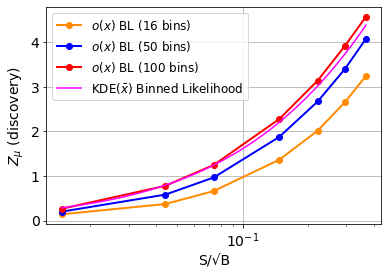

In [37]:
# We can do a quick Z bin-loglikelihood calculation using the computed KDE
# this is to check the KDE here, because we use KDE to avoid binning


# in each ensemble we use B=50k
print('B_expected: ', B_expected)

# values of S / sqrt{B} to test 
soversqrtB = np.linspace(SsqrtB[0],SsqrtB[-1],100)



# Let's find out the expected number of B and S events in each bin:

# total number of B * B_pdf value in each bin * bin size
Bd = B_expected*dens_bkg*(s_vals[1]-s_vals[0])



# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
Bd_noceros = []
for i in range(len(Bd)):
    if Bd[i]!=0:
        Bd_noceros.append(Bd[i])

min_back = min(Bd_noceros)

# replace the zeros
for i in range(len(Bd)):
    if Bd[i]==0:
        Bd[i] = min_back




# Now calculate Z using the Binned Likelihood formula

Zvals = np.zeros(len(soversqrtB))

for nval, val in enumerate(soversqrtB):
    # S events in each bin: 
    # value of S/sqrt{B} * sqrt{B} * S_pdf value in each bin * bin size
    Sd = val*np.sqrt(B_expected)*dens_sig*(s_vals[1]-s_vals[0])
    
    # Z value:
    #Zvals[nval]= np.sqrt(2.0*np.sum(((Sd+Bd)*np.log(1.0+Sd/Bd)-Sd))) # Discovery
    Zvals[nval]= np.sqrt(2.0*np.sum(Bd*np.log(Bd/(Sd+Bd))+Sd)) # Exclusion

    
    
    
# PLOT

plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins, '-o', color='red', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(soversqrtB, Zvals, color='magenta', label=r'KDE$(\bar{x})$ Binned Likelihood') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

#### MLL KDE

In [38]:
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

In [39]:
#################################################
# Uncertainties in tau pT using the dataset upB #
#################################################

KDE_SM_pred_SMupB = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SMupB, np.zeros(len(pred_XG_SMupB)) ]) )
KDE_NP_pred_SMupB = np.exp(kde_sig.score_samples(np.c_[pred_XG_SMupB, np.ones(len(pred_XG_SMupB)) ]) )


# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SMupB / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SMupB / factor_aux_NP

B_expected:  4596
S_expected:  1
S/$\sqrt{B}$:  0.014750610319128192
n_ensembles (initial):  2000

 If  919  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take long... 



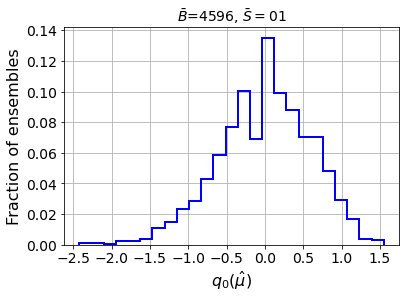

muhat mean:  0.05799549549549549
median q_muhat_KDE:  0.027828981065768144
Z_KDE:  0.16682020580783416
Z_KDE mu=0:  0.09996123402825173
std Z_KDE:  0.9774130263027544
std Z_KDE mu=0:  1.6343515672810238

 -------------------------------- 

B_expected:  4596
S_expected:  3
S/$\sqrt{B}$:  0.04425183095738457
n_ensembles (initial):  2000

 If  919  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take long... 



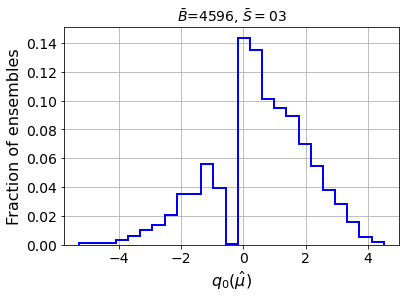

muhat mean:  0.13871058558558558
median q_muhat_KDE:  0.5846769490136117
Z_KDE:  0.7646417128391647
Z_KDE mu=0:  0.7619651067469241
std Z_KDE:  0.6544079890408944
std Z_KDE mu=0:  0.6659295593957674

 -------------------------------- 

B_expected:  4596
S_expected:  5
S/$\sqrt{B}$:  0.07375305159564095
n_ensembles (initial):  2000

 If  921  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take long... 



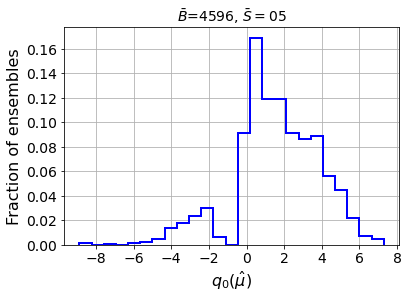

muhat mean:  0.178125
median q_muhat_KDE:  1.585263810199503
Z_KDE:  1.2590725992568907
Z_KDE mu=0:  1.257350062750661
std Z_KDE:  0.6744132597366259
std Z_KDE mu=0:  0.6993056259652214

 -------------------------------- 

B_expected:  4596
S_expected:  10
S/$\sqrt{B}$:  0.1475061031912819
n_ensembles (initial):  2000

 If  921  =  278    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take long... 



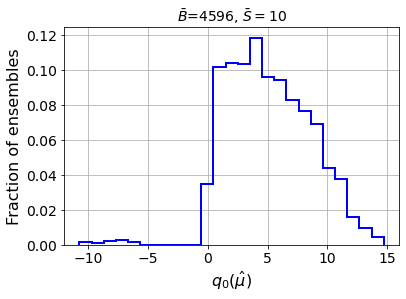

muhat mean:  0.16632882882882882
median q_muhat_KDE:  4.857166065654328
Z_KDE:  2.203897925416313
Z_KDE mu=0:  2.2009061329964363
std Z_KDE:  0.7429895059091192
std Z_KDE mu=0:  0.81191179476067

 -------------------------------- 

B_expected:  4596
S_expected:  15
S/$\sqrt{B}$:  0.22125915478692287
n_ensembles (initial):  2000

 If  923  =  279    then the proposed range has to be extended
n_ensembles (actual):  1777

 This may take long... 



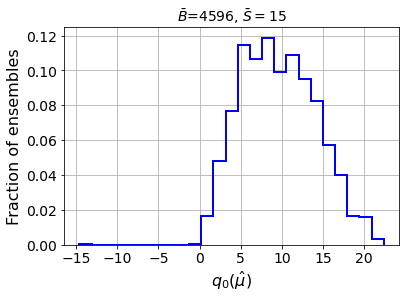

muhat mean:  0.12084974676420934
median q_muhat_KDE:  9.324421694168137
Z_KDE:  3.053591605661788
Z_KDE mu=0:  3.0495365680035396
std Z_KDE:  0.7374648503294879
std Z_KDE mu=0:  0.8306702426130709

 -------------------------------- 

B_expected:  4596
S_expected:  20
S/$\sqrt{B}$:  0.2950122063825638
n_ensembles (initial):  2000

 If  923  =  279    then the proposed range has to be extended
n_ensembles (actual):  1777

 This may take long... 



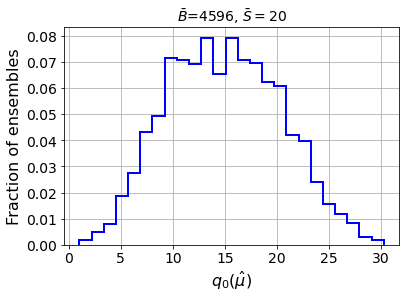

muhat mean:  0.08511536297129994
median q_muhat_KDE:  14.86613199667189
Z_KDE:  3.8556623291818344
Z_KDE mu=0:  3.8550658233633937
std Z_KDE:  0.6998475166080693
std Z_KDE mu=0:  0.7872532733068531

 -------------------------------- 

B_expected:  4596
S_expected:  25
S/$\sqrt{B}$:  0.3687652579782048
n_ensembles (initial):  2000

 If  925  =  279    then the proposed range has to be extended
n_ensembles (actual):  1776

 This may take long... 



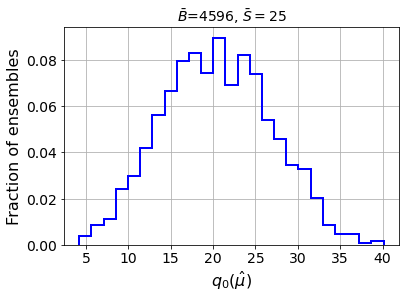

muhat mean:  0.07240990990990992
median q_muhat_KDE:  20.301940399597527
Z_KDE:  4.505767459556421
Z_KDE mu=0:  4.508795445743276
std Z_KDE:  0.7033876905894916
std Z_KDE mu=0:  0.7902547061209255

 -------------------------------- 



In [40]:
store_muhat_mean_MLL_KDE = []

store_Z_MLL_KDE = []
store_Z_MLL_KDE_mu0 = []

store_Z_MLL_KDE_std = []
store_Z_MLL_KDE_std_mu0 = []


indices = [i for i in range(len(KDE_NP_pred_SM))]


for iii in range(len(SB_ratio)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    print('n_ensembles (initial): ', n_ensembles)


    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######



    print('\n This may take long... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    muhat_selected_KDE_list = []
    q_muhat_KDE = []
    q_muhat_KDE_mu0 = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            # KDE
            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

            KDE_SM_pred_SM_shuf = []
            KDE_NP_pred_SM_shuf = []

            for i in ran_ind:
                KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
                KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

            KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
            KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)





            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )



            

            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
            
            sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1., 0.05).tolist()

            muhat_selected_KDE = 0.0

            if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break

            elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_KDE = muhat_test[vv]
                        break


            muhat_selected_KDE_list.append(muhat_selected_KDE)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            #q_muhat_mu0.append( 2 * ( (-1.*1. * S_expected[iii]) + sum( [np.log( 1 + ( (1.*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat_KDE.append( 2 * ( ( (1.-muhat_selected_KDE) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (muhat_selected_KDE*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            q_muhat_KDE_mu0.append( 2 * ( ( (1.-0.) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (0.*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


    # Histogram of q_muhats

    weights = np.ones_like(q_muhat_KDE)/float(len(q_muhat_KDE))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_KDE, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian
    
    # Remove nan if any
    q_muhat_KDE_mu0 = [x for x in q_muhat_KDE_mu0 if x == x]
    for jk in range(len(q_muhat_KDE_mu0)):
        if q_muhat_KDE_mu0[jk] < 0:
            q_muhat_KDE_mu0[jk] = 0

    q_muhat_KDE_median_mu0 = np.median(q_muhat_KDE_mu0)
    Z_KDE_mu0 = abs(q_muhat_KDE_median_mu0)**0.5
    store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)
    
    q_muhat_KDE_std_mu0 = np.std(q_muhat_KDE_mu0)
    Z_KDE_std_mu0 = q_muhat_KDE_std_mu0/(2.*Z_KDE_mu0)
    store_Z_MLL_KDE_std_mu0.append(Z_KDE_std_mu0)
    

    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean_MLL_KDE = np.mean(muhat_selected_KDE_list)
    store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)

    # Remove nan if any
    q_muhat_KDE = [x for x in q_muhat_KDE if x == x]
    for jk in range(len(q_muhat_KDE)):
        if q_muhat_KDE[jk] < 0:
            q_muhat_KDE[jk] = 0

    q_muhat_KDE_median = np.median(q_muhat_KDE)
    Z_KDE = abs(q_muhat_KDE_median)**0.5
    store_Z_MLL_KDE.append(Z_KDE)
    
    q_muhat_KDE_std = np.std(q_muhat_KDE)
    Z_KDE_std = q_muhat_KDE_std/(2.*Z_KDE)
    store_Z_MLL_KDE_std.append(Z_KDE_std)

    print('muhat mean: ', muhat_mean_MLL_KDE)
    print('median q_muhat_KDE: ', q_muhat_KDE_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE mu=0: ', Z_KDE_mu0)
    print('std Z_KDE: ', Z_KDE_std)
    print('std Z_KDE mu=0: ', Z_KDE_std_mu0)

    print('\n -------------------------------- \n')

In [41]:
print(store_muhat_mean_MLL_KDE)

print(store_Z_MLL_KDE)
print(store_Z_MLL_KDE_mu0)

print(store_Z_MLL_KDE_std)
print(store_Z_MLL_KDE_std_mu0)

[0.05799549549549549, 0.13871058558558558, 0.178125, 0.16632882882882882, 0.12084974676420934, 0.08511536297129994, 0.07240990990990992]
[0.16682020580783416, 0.7646417128391647, 1.2590725992568907, 2.203897925416313, 3.053591605661788, 3.8556623291818344, 4.505767459556421]
[0.09996123402825173, 0.7619651067469241, 1.257350062750661, 2.2009061329964363, 3.0495365680035396, 3.8550658233633937, 4.508795445743276]
[0.9774130263027544, 0.6544079890408944, 0.6744132597366259, 0.7429895059091192, 0.7374648503294879, 0.6998475166080693, 0.7033876905894916]
[1.6343515672810238, 0.6659295593957674, 0.6993056259652214, 0.81191179476067, 0.8306702426130709, 0.7872532733068531, 0.7902547061209255]


In [48]:
# To use if you dont want to run everything again. Its the previous results
store_muhat_mean_MLL_KDE = [0.05799549549549549, 0.13871058558558558, 0.178125, 0.16632882882882882, 0.12084974676420934, 0.08511536297129994, 0.07240990990990992]

store_Z_MLL_KDE = [0.16682020580783416, 0.7646417128391647, 1.2590725992568907, 2.203897925416313, 3.053591605661788, 3.8556623291818344, 4.505767459556421]
store_Z_MLL_KDE_mu0 = [0.09996123402825173, 0.7619651067469241, 1.257350062750661, 2.2009061329964363, 3.0495365680035396, 3.8550658233633937, 4.508795445743276]

store_Z_MLL_KDE_std = [0.9774130263027544, 0.6544079890408944, 0.6744132597366259, 0.7429895059091192, 0.7374648503294879, 0.6998475166080693, 0.7033876905894916]
store_Z_MLL_KDE_std_mu0 = [1.6343515672810238, 0.6659295593957674, 0.6993056259652214, 0.81191179476067, 0.8306702426130709, 0.7872532733068531, 0.7902547061209255]

In [49]:
store_Z_MLL_KDE_plus = [i+j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]
store_Z_MLL_KDE_min = [i-j for i, j in zip(store_Z_MLL_KDE, store_Z_MLL_KDE_std)]

store_Z_MLL_KDE_mu0_plus = [i+j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]
store_Z_MLL_KDE_mu0_min = [i-j for i, j in zip(store_Z_MLL_KDE_mu0, store_Z_MLL_KDE_std_mu0)]

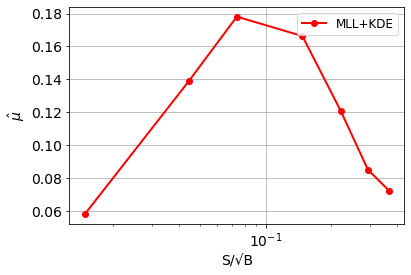

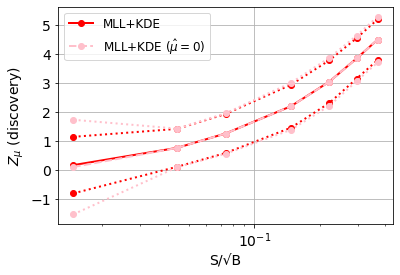

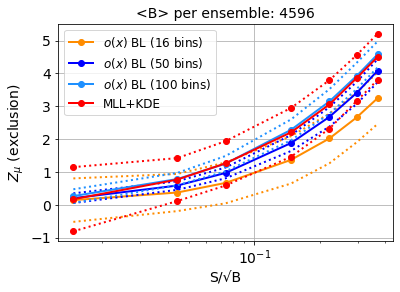

In [50]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )




plt.figure()
lw = 2

plt.plot(posX, store_muhat_mean_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.show()




plt.figure()
lw = 2

plt.plot(posX, store_Z_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')
plt.plot(posX, store_Z_MLL_KDE_plus, ':o', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_min, ':o', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_mu0, '--o', color='pink', lw=lw, label=r'MLL+KDE ($\hat{\mu}=0$)')
plt.plot(posX, store_Z_MLL_KDE_mu0_plus, ':o', color='pink', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_mu0_min, ':o', color='pink', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()




plt.figure()
lw = 2

plt.plot(posX, store_Z_bins_XG_16bins, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)') 
plt.plot(posX, store_Z_bins_XG_16bins_plus, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_16bins_min, ':', color='darkorange', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)') 
plt.plot(posX, store_Z_bins_XG_50bins_plus, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_50bins_min, ':', color='blue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins, '-o', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)') 
plt.plot(posX, store_Z_bins_XG_100bins_plus, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_bins_XG_100bins_min, ':', color='dodgerblue', lw=lw) 
plt.plot(posX, store_Z_MLL_KDE, '-o', color='red', lw=lw, label='MLL+KDE')
plt.plot(posX, store_Z_MLL_KDE_plus, ':o', color='red', lw=lw)
plt.plot(posX, store_Z_MLL_KDE_min, ':o', color='red', lw=lw)

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### Interpolate

In [51]:
# if Z < 0 -> Z=0

store_Z_bins_XG_16bins = [0 if i < 0 else i for i in store_Z_bins_XG_16bins]
store_Z_bins_XG_16bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_16bins_plus]
store_Z_bins_XG_16bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_16bins_min]

store_Z_bins_XG_50bins = [0 if i < 0 else i for i in store_Z_bins_XG_50bins]
store_Z_bins_XG_50bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_50bins_plus]
store_Z_bins_XG_50bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_50bins_min]

store_Z_bins_XG_100bins = [0 if i < 0 else i for i in store_Z_bins_XG_100bins]
store_Z_bins_XG_100bins_plus = [0 if i < 0 else i for i in store_Z_bins_XG_100bins_plus]
store_Z_bins_XG_100bins_min = [0 if i < 0 else i for i in store_Z_bins_XG_100bins_min]

store_Z_MLL_KDE = [0 if i < 0 else i for i in store_Z_MLL_KDE]
store_Z_MLL_KDE_plus = [0 if i < 0 else i for i in store_Z_MLL_KDE_plus]
store_Z_MLL_KDE_min = [0 if i < 0 else i for i in store_Z_MLL_KDE_min]

In [52]:
# add zero

posX = [0.001] + posX

store_Z_bins_XG_16bins = [0] + store_Z_bins_XG_16bins
store_Z_bins_XG_16bins_plus = [0] + store_Z_bins_XG_16bins_plus
store_Z_bins_XG_16bins_min = [0] + store_Z_bins_XG_16bins_min

store_Z_bins_XG_50bins = [0] + store_Z_bins_XG_50bins
store_Z_bins_XG_50bins_plus = [0] + store_Z_bins_XG_50bins_plus
store_Z_bins_XG_50bins_min = [0] + store_Z_bins_XG_50bins_min

store_Z_bins_XG_100bins = [0] + store_Z_bins_XG_100bins
store_Z_bins_XG_100bins_plus = [0] + store_Z_bins_XG_100bins_plus
store_Z_bins_XG_100bins_min = [0] + store_Z_bins_XG_100bins_min

store_Z_MLL_KDE = [0] + store_Z_MLL_KDE
store_Z_MLL_KDE_plus = [0] + store_Z_MLL_KDE_plus
store_Z_MLL_KDE_min = [0] + store_Z_MLL_KDE_min

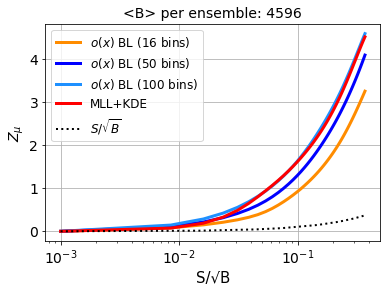

In [53]:
  
# Interpolation, cubic
f_16bins = interp1d(posX, store_Z_bins_XG_16bins, kind='cubic')
f_16bins_plus = interp1d(posX, store_Z_bins_XG_16bins_plus, kind='cubic')
f_16bins_min = interp1d(posX, store_Z_bins_XG_16bins_min, kind='cubic')

f_50bins = interp1d(posX, store_Z_bins_XG_50bins, kind='cubic')
f_50bins_plus = interp1d(posX, store_Z_bins_XG_50bins_plus, kind='cubic')
f_50bins_min = interp1d(posX, store_Z_bins_XG_50bins_min, kind='cubic')

f_100bins = interp1d(posX, store_Z_bins_XG_100bins, kind='cubic')
f_100bins_plus = interp1d(posX, store_Z_bins_XG_100bins_plus, kind='cubic')
f_100bins_min = interp1d(posX, store_Z_bins_XG_100bins_min, kind='cubic')

f_MLL_KDE = interp1d(posX, store_Z_MLL_KDE, kind='cubic')
f_MLL_KDE_plus = interp1d(posX, store_Z_MLL_KDE_plus, kind='cubic')
f_MLL_KDE_min = interp1d(posX, store_Z_MLL_KDE_min, kind='cubic')



# x to plot
plotX = np.linspace(min(posX), max(posX), num=50, endpoint=True)



plt.figure()
lw = 2

plt.plot(plotX, f_16bins(plotX), '-', color='darkorange', lw=3, label=r'$o(x)$ BL (16 bins)')
plt.plot(plotX, f_50bins(plotX), '-', color='blue', lw=3, label=r'$o(x)$ BL (50 bins)')
plt.plot(plotX, f_100bins(plotX), '-', color='dodgerblue', lw=3, label=r'$o(x)$ BL (100 bins)')
plt.plot(plotX, f_MLL_KDE(plotX), '-', color='red', lw=3, label='MLL+KDE')
plt.plot(posX, posX, ':', color='black', lw=lw, label=r'$S/\sqrt{B}$')

#plt.ylim([0., 6])
#plt.xlim([0.06, 10])
#plt.ylim([0., 3])
#plt.xlim([0.1, 0.2])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=15)
plt.ylabel('$Z_{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [54]:
# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solve(fn, value, x=0.1, maxtries=1000, maxerr=0.00001):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

In [55]:
# We need the ratio of the fiducial cross-sections for different values of beta to rescale

beta = [0,0.1,0.3,0.5,0.7,0.9,1]

# m_LQ = [ 1200, 1400, 1600, 1800 ]  GeV
ind_mass = 1

fidcross_beta00 = [0.01105192, 0.0030939120000000003, 0.0010050880000000001, 0.00029555639999999996]
fidcross_beta01 = [0.0491575, 0.01736763, 0.005743949999999999, 0.0019831400000000004]
fidcross_beta03 = [0.09334300000000001, 0.030734200000000003, 0.009711, 0.00331056]
fidcross_beta05 = [0.1169796, 0.03694208, 0.01213745, 0.0041233500000000005]
fidcross_beta07 = [0.10827519999999999, 0.03488576, 0.011685379999999999, 0.004226183999999999]
fidcross_beta09 = [0.0777504, 0.02674464, 0.00962278, 0.0031703000000000005]
fidcross_beta1 = [0.0376428, 0.01194092, 0.003957376, 0.0013051116]


S00 = round(300 * crossfidNP) * (fidcross_beta00[ind_mass]/fidcross_beta05[ind_mass])
S01 = round(300 * crossfidNP) * (fidcross_beta01[ind_mass]/fidcross_beta05[ind_mass])
S03 = round(300 * crossfidNP) * (fidcross_beta03[ind_mass]/fidcross_beta05[ind_mass])
S05 = round(300 * crossfidNP) * (fidcross_beta05[ind_mass]/fidcross_beta05[ind_mass])
S07 = round(300 * crossfidNP) * (fidcross_beta07[ind_mass]/fidcross_beta05[ind_mass])
S09 = round(300 * crossfidNP) * (fidcross_beta09[ind_mass]/fidcross_beta05[ind_mass])
S1 = round(300 * crossfidNP) * (fidcross_beta1[ind_mass]/fidcross_beta05[ind_mass])


S_exp_LQ = [S00,S01,S03,S05,S07,S09,S1]

print(S_exp_LQ)

[1.6750069297668135, 9.402627031287896, 16.639128062090712, 20.0, 18.886732961435847, 14.479228023976994, 6.4646711825647065]


In [56]:
# Finally, the value of Z for each value of beta, for this particular LQ

results_16bins_beta = []
results_16bins_beta_plus = []
results_16bins_beta_min = []

results_50bins_beta = []
results_50bins_beta_plus = []
results_50bins_beta_min = []

results_100bins_beta = []
results_100bins_beta_plus = []
results_100bins_beta_min = []

results_MLL_KDE_beta = []
results_MLL_KDE_beta_plus = []
results_MLL_KDE_beta_min = []



for signal in S_exp_LQ:    
    results_16bins_beta.append( f_16bins(signal/(B_expected**0.5)).tolist() )
    results_16bins_beta_plus.append( f_16bins_plus(signal/(B_expected**0.5)).tolist() )
    results_16bins_beta_min.append( f_16bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_50bins_beta.append( f_50bins(signal/(B_expected**0.5)).tolist() )
    results_50bins_beta_plus.append( f_50bins_plus(signal/(B_expected**0.5)).tolist() )
    results_50bins_beta_min.append( f_50bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_100bins_beta.append( f_100bins(signal/(B_expected**0.5)).tolist() )
    results_100bins_beta_plus.append( f_100bins_plus(signal/(B_expected**0.5)).tolist() )
    results_100bins_beta_min.append( f_100bins_min(signal/(B_expected**0.5)).tolist() )
    
    results_MLL_KDE_beta.append( f_MLL_KDE(signal/(B_expected**0.5)).tolist() )
    results_MLL_KDE_beta_plus.append( f_MLL_KDE_plus(signal/(B_expected**0.5)).tolist() )
    results_MLL_KDE_beta_min.append( f_MLL_KDE_min(signal/(B_expected**0.5)).tolist() )

In [57]:
print( results_16bins_beta )
print( results_16bins_beta_plus )
print( results_16bins_beta_min )

print( results_50bins_beta )
print( results_50bins_beta_plus )
print( results_50bins_beta_min )

print( results_100bins_beta )
print( results_100bins_beta_plus )
print( results_100bins_beta_min )

print( results_MLL_KDE_beta )
print( results_MLL_KDE_beta_plus )
print( results_MLL_KDE_beta_min )

np.savetxt('saved-results/LQdown1400GeV.txt', [results_16bins_beta,
                                            results_16bins_beta_plus,
                                            results_16bins_beta_min,
                                            results_50bins_beta,
                                            results_50bins_beta_plus,
                                            results_50bins_beta_min,
                                            results_100bins_beta,
                                            results_100bins_beta_plus,
                                            results_100bins_beta_min,
                                            results_MLL_KDE_beta,
                                            results_MLL_KDE_beta_plus,
                                            results_MLL_KDE_beta_min])

[0.21936997404762543, 1.2862722553727157, 2.229647376552028, 2.6565726126881746, 2.5168392253887415, 1.9506520934264857, 0.8801352457709719]
[0.9700726173744197, 2.009002435049397, 2.991770287757573, 3.4143873838949332, 3.2766617275741927, 2.703697493845738, 1.5811433201282594]
[-0.0006181849624307275, 0.5599132235008334, 1.4661533383229006, 1.8987578414814152, 1.7562292809949738, 1.1984819097412671, 0.163377920019771]
[0.3316196125815554, 1.7757379713162795, 2.9184348911610516, 3.4018759939337584, 3.2441958793706327, 2.5953201867452504, 1.2453549424425596]
[0.4988264364292215, 2.012641760547451, 3.229907142742528, 3.739143130693763, 3.5741584405406925, 2.885243087996063, 1.4451572854802492]
[0.16441278873388956, 1.538834182085108, 2.606962639579575, 3.0646088571737544, 2.914233318200572, 2.3053972854944367, 1.0455525994048702]
[0.44367477698981744, 2.1670650042366004, 3.407387811011862, 3.9204894333368876, 3.7554164951615214, 3.0587736578529485, 1.5704869511214479]
[0.6806993379111965

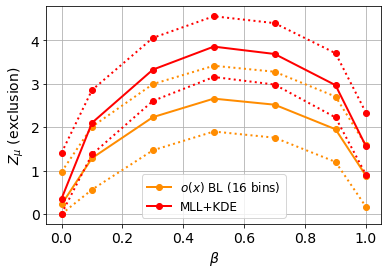

In [58]:
plt.figure()
lw = 2

plt.plot(beta, results_16bins_beta, '-o', color='darkorange', lw=lw, label=r'$o(x)$ BL (16 bins)')
plt.plot(beta, results_16bins_beta_plus, ':o', color='darkorange', lw=lw) 
plt.plot(beta, results_16bins_beta_min, ':o', color='darkorange', lw=lw) 

# plt.plot(beta, results_50bins_beta, '-o', color='blue', lw=lw, label=r'$o(x)$ BL (50 bins)')
# plt.plot(beta, results_50bins_beta_plus, ':o', color='blue', lw=lw) 
# plt.plot(beta, results_50bins_beta_min, ':o', color='blue', lw=lw) 

# plt.plot(beta, results_100bins_beta, '-o', color='dodgerblue', lw=lw, label=r'$o(x)$ BL (100 bins)')
# plt.plot(beta, results_100bins_beta_plus, ':o', color='dodgerblue', lw=lw) 
# plt.plot(beta, results_100bins_beta_min, ':o', color='dodgerblue', lw=lw) 

plt.plot(beta, results_MLL_KDE_beta, '-o', color='red', lw=lw, label=r'MLL+KDE')
plt.plot(beta, results_MLL_KDE_beta_plus, ':o', color='red', lw=lw) 
plt.plot(beta, results_MLL_KDE_beta_min, ':o', color='red', lw=lw) 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
#plt.xscale('log')
plt.xlabel(r'$\beta$', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.title('<B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(fontsize=12)
plt.show()